In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

#!pip install --upgrade nltk
!pip install emoji

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import emoji

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
root = '/content/drive/MyDrive/NLP/Davide/irony_davide_datasets/'
#root = '/kaggle/input/irony-datasets/'

x_train = pd.read_csv(root + 'x_train.csv')
x_test = pd.read_csv(root + 'x_test.csv')
x_val = pd.read_csv(root + 'x_val.csv')
y_train = pd.read_csv(root + 'y_train.csv')
y_test = pd.read_csv(root + 'y_test.csv')
y_val = pd.read_csv(root + 'y_val.csv')

In [5]:
hyperparameters = {
    "epochs": 18,
    "learning_rate": 5e-5,   #1e-5
    "batch_size": 8,  #accura...
    "dropout": 0.3,   # o 0.3
    "weight_decay": 1e-5,  #1e-3
    "stopwords": False,
    "language_model": "vinai/bertweet-base", #bert-base-uncased
    "layers": 1,
    "h_dim": 768,
    "bilstm": False,
    "patience": 5,
    "min_delta": 0.01,
    "extra_features": 5
}

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, hashtag_count, avg_ironic_ratio, ironic_hashtag_count, non_ironic_hashtag_count, hashtag_irony_index, y, stopwords):  #nn_count
        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                                            not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]
        #self.emoji_count = [torch.tensor(count) for count in emoji_count]
        #self.ironic_emoji = [torch.tensor(ironic) for ironic in ironic_emoji]
        #self.non_ironic_emoji = [torch.tensor(non_ironic) for non_ironic in non_ironic_emoji]
        #self.nn_count = [torch.tensor(count) for count in nn_count]  # Nuova colonna
        self.hashtag_count = [torch.tensor(count) for count in hashtag_count]
        self.avg_ironic_ratio = [torch.tensor(ratio) for ratio in avg_ironic_ratio]
        self.ironic_hashtag_count = [torch.tensor(count) for count in ironic_hashtag_count]
        self.non_ironic_hashtag_count = [torch.tensor(count) for count in non_ironic_hashtag_count]
        self.hashtag_irony_index = [torch.tensor(index) for index in hashtag_irony_index]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        #batch_emoji_count = np.array(self.emoji_count[idx])
        #batch_ironic_emoji = np.array(self.ironic_emoji[idx])
        #batch_non_ironic_emoji = np.array(self.non_ironic_emoji[idx])
        #batch_nn_count = np.array(self.nn_count[idx])  # Aggiunto NN_count
        batch_hashtag_count = np.array(self.hashtag_count[idx])
        batch_avg_ironic_ratio = np.array(self.avg_ironic_ratio[idx])
        batch_ironic_hashtag_count = np.array(self.ironic_hashtag_count[idx])
        batch_non_ironic_hashtag_count = np.array(self.non_ironic_hashtag_count[idx])
        batch_hashtag_irony_index = np.array(self.hashtag_irony_index[idx])

        return batch_texts, batch_hashtag_count, batch_avg_ironic_ratio, batch_ironic_hashtag_count, batch_non_ironic_hashtag_count, batch_hashtag_irony_index, batch_labels
        #batch_emoji_count, batch_ironic_emoji, batch_non_ironic_emoji, batch_nn_count




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
x_train

,hashtag_count,avg_ironic_ratio,ironic_hashtag_count,non_ironic_hashtag_count,hashtag_irony_index,text
0,0,0.0,0,0,0.0,"@user not surprised, it was epic. \n"
1,0,0.0,0,0,0.0,"Sooo mad right now, great way to start my day \n"
2,0,0.0,0,0,0.0,Lol well done swans \n
3,1,1.0,1,0,1.0,@user thanks for the wake up wrap and coffee t...
4,0,0.0,0,0,0.0,So excited to spend the next 12 hours at schoo...
...,...,...,...,...,...,...
1712,0,0.0,0,0,0.0,Ay after 2 hours nareceive ko rin yung message...
1713,1,0.0,0,1,0.0,@user Alone Tonight cause its a personal song ...
1714,1,0.0,0,1,0.0,A year ago this would be just a writing on a t...
1715,0,0.0,0,0,0.0,@user @user yeah & we wont talk about how the ...


In [8]:
train_dataset = Dataset(x_train['text'], x_train['hashtag_count'], x_train['avg_ironic_ratio'], x_train['ironic_hashtag_count'], x_train['non_ironic_hashtag_count'], x_train['hashtag_irony_index'], y_train.squeeze(1), hyperparameters["stopwords"])
val_dataset = Dataset(x_val['text'], x_val['hashtag_count'], x_val['avg_ironic_ratio'], x_val['ironic_hashtag_count'], x_val['non_ironic_hashtag_count'], x_val['hashtag_irony_index'], y_val.squeeze(1), hyperparameters["stopwords"])
test_dataset = Dataset(x_test['text'], x_test['hashtag_count'], x_test['avg_ironic_ratio'], x_test['ironic_hashtag_count'], x_test['non_ironic_hashtag_count'], x_test['hashtag_irony_index'], y_test.squeeze(1), hyperparameters["stopwords"])

#val_dataset = Dataset(x_val['text'], x_val['emoji_count'], x_val['has_ironic_emoji'], x_val['has_non_ironic_emoji'], x_val['NN_count'], y_val.squeeze(1), hyperparameters["stopwords"])
#test_dataset = Dataset(x_test['text'], x_test['emoji_count'], x_test['has_ironic_emoji'], x_test['has_non_ironic_emoji'], x_test['NN_count'], y_test.squeeze(1), hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 229/229 [00:00<00:00, 181568.17it/s]


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza



In [10]:
class ClassifierDeep(nn.Module):

    def __init__(self, hdim, dropout, model_name, extra_features = hyperparameters["extra_features"]):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)

        self.classifier = nn.Sequential(
          nn.Linear(hdim + extra_features, hdim),
          nn.BatchNorm1d(hdim),
          nn.Dropout(dropout),
          nn.ReLU(),
          nn.Linear(hdim, 16),
          nn.BatchNorm1d(16),
          nn.Dropout(dropout),
          nn.ReLU(),
          nn.Linear(16, 1),
          nn.Sigmoid()
          )




    #def forward(self, input_id_text, attention_mask, emoji_count, has_ironic_emoji, has_non_ironic_emoji, nn_count):
    def forward(self, input_id_text, attention_mask, hashtag_count, avg_ironic_ratio, ironic_hashtag_count, non_ironic_hashtag_count, hashtag_irony_index):
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        #output = torch.cat((output, emoji_count.unsqueeze(1), has_ironic_emoji.unsqueeze(1), has_non_ironic_emoji.unsqueeze(1), nn_count.unsqueeze(1)), dim=1)
        output = torch.cat((output, hashtag_count.unsqueeze(1), avg_ironic_ratio.unsqueeze(1), ironic_hashtag_count.unsqueeze(1), non_ironic_hashtag_count.unsqueeze(1), hashtag_irony_index.unsqueeze(1)), dim=1)
        return self.classifier(output)

In [11]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device, scheduler):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    #for batch_texts, batch_emoji_count, batch_ironic_emoji, batch_non_ironic_emoji, batch_nn_count, batch_labels in tqdm(dataloader, desc='training set'):
    for batch_texts, batch_hashtag_count, batch_avg_ironic_ratio, batch_ironic_hashtag_count, batch_non_ironic_hashtag_count, batch_hashtag_irony_index, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts),
                           add_special_tokens=True,
                           return_tensors='pt',
                           padding='max_length',
                           max_length = 128,
                           truncation=True)

        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        #batch_emoji_count = batch_emoji_count.float().to(device)
        #batch_ironic_emoji = batch_ironic_emoji.float().to(device)
        #batch_non_ironic_emoji = batch_non_ironic_emoji.float().to(device)
        #batch_nn_count = batch_nn_count.float().to(device)
        batch_hashtag_count = batch_hashtag_count.float().to(device)
        batch_avg_ironic_ratio = batch_avg_ironic_ratio.float().to(device)
        batch_ironic_hashtag_count = batch_ironic_hashtag_count.float().to(device)
        batch_non_ironic_hashtag_count = batch_non_ironic_hashtag_count.float().to(device)
        batch_hashtag_irony_index = batch_hashtag_irony_index.float().to(device)
        batch_labels = batch_labels.float().to(device)


        #output = model(input_id_texts, mask_texts, batch_emoji_count, batch_ironic_emoji, batch_non_ironic_emoji, batch_nn_count).squeeze(1)
        output = model(input_id_texts, mask_texts, batch_hashtag_count, batch_avg_ironic_ratio, batch_ironic_hashtag_count, batch_non_ironic_hashtag_count, batch_hashtag_irony_index).squeeze(1)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        ##### GRADIENT CLIPPING #####
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #############################
        optimizer.step()

        ###### SCHEDULER ######
        # Scheduler step
        scheduler.step()
        print(optimizer.param_groups[0]["lr"])
        #######################

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        preds = (output > 0.5).float()  # Soglia di 0.5 per la classificazione binaria
        epoch_acc += (preds == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        #batch_emoji_count = batch_emoji_count.detach().cpu()
        #batch_ironic_emoji = batch_ironic_emoji.detach().cpu()
        #batch_non_ironic_emoji = batch_non_ironic_emoji.detach().cpu()
        #batch_nn_count = batch_nn_count.detach().cpu()
        batch_hashtag_count = batch_hashtag_count.detach().cpu()
        batch_avg_ironic_ratio = batch_avg_ironic_ratio.detach().cpu()
        batch_ironic_hashtag_count = batch_ironic_hashtag_count.detach().cpu()
        batch_non_ironic_hashtag_count = batch_non_ironic_hashtag_count.detach().cpu()
        batch_hashtag_irony_index = batch_hashtag_irony_index.detach().cpu()
        output = output.detach().cpu()


    return epoch_loss/len(dataloader), epoch_acc


In [12]:
from sklearn.metrics import f1_score

def test_loop(model, dataloader, tokenizer, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_texts, batch_hashtag_count, batch_avg_ironic_ratio, batch_ironic_hashtag_count, batch_non_ironic_hashtag_count, batch_hashtag_irony_index, batch_labels in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts),
                               add_special_tokens=True,
                               return_tensors='pt',
                               padding='max_length',
                               max_length=128,
                               truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_hashtag_count = batch_hashtag_count.float().to(device)
            batch_avg_ironic_ratio = batch_avg_ironic_ratio.float().to(device)
            batch_ironic_hashtag = batch_ironic_hashtag_count.float().to(device)
            batch_non_ironic_hashtag = batch_non_ironic_hashtag_count.float().to(device)
            batch_hashtag_irony_index = batch_hashtag_irony_index.float().to(device)
            batch_labels = batch_labels.float().to(device)

            output = model(input_id_texts, mask_texts, batch_hashtag_count, batch_avg_ironic_ratio, batch_ironic_hashtag, batch_non_ironic_hashtag, batch_hashtag_irony_index).squeeze(1)

            # Calcola la loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # Genera predizioni binarie
            preds = (output > 0.5).float()

            # Calcola l'accuracy
            epoch_acc += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_hashtag_count = batch_hashtag_count.detach().cpu()
            batch_avg_ironic_ratio = batch_avg_ironic_ratio.detach().cpu()
            batch_ironic_hashtag = batch_ironic_hashtag_count.detach().cpu()
            batch_non_ironic_hashtag = batch_non_ironic_hashtag_count.detach().cpu()
            batch_hashtag_irony_index = batch_hashtag_irony_index.detach().cpu()
            output = output.detach().cpu()

            f1 = f1_score(all_labels, all_preds)

    return epoch_loss/len(dataloader), epoch_acc, f1


In [13]:
def unfreeze_layers(model, freeze_up_to_layer):
    # Itera su tutti i parametri del modello
    for name, param in model.named_parameters():
        # Gestisce l'encoder e altri componenti
        if 'encoder.layer' in name:
            # Estrai il numero del layer
            try:
                layer_number = int(name.split('.')[2])  # esempio "encoder.layer.11.attention.self.query.weight"
            except ValueError:
                continue  # salta se non riesci a ottenere il numero del layer

            # Congela i parametri fino al livello specificato
            if layer_number < freeze_up_to_layer:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # Gestione degli embeddings (se vuoi congelarli o meno)
        elif 'embeddings' in name:
            param.requires_grad = False  # Congela gli embeddings (o cambia se vuoi sbloccarli)

        # Gestione della parte del pooler e della testa di classificazione (se devi allenare queste parti)
        elif 'pooler' in name or 'classifier' in name:
            param.requires_grad = True  # Assicurati che questi componenti siano allenati

        # Stampa dello stato di "requires_grad" per ogni parametro
        print(f"{name} - requires_grad = {param.requires_grad}")


In [14]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, model_name, train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None,            # possibile scheduler per monitorare l'andamento di un iperparametro
               freeze_every_n_epochs=5,  # il numero di epoche dopo le quali sbloccare i layer
               freeze_up_to_layer=8):    # il numero di layer iniziali da congelare

    # Congelamento progressivo all'inizio
    unfreeze_layers(model, freeze_up_to_layer)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []
    train_acc = []
    validation_acc = []
    test_acc = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    all_emojis = list(emoji.EMOJI_DATA.keys())
    emoji_tokens = [emoji.demojize(e) for e in all_emojis]
    tokenizer.add_tokens(emoji_tokens)
    tokenizer.add_tokens(["@user"])
    model.lm_model.resize_token_embeddings(len(tokenizer))

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device, scheduler)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # Validation se è presente la callback di early stopping
        if early_stopping != None:
            epoch_validate_loss, epoch_validate_acc, _, = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device)
            validation_loss.append(epoch_validate_loss)
            validation_acc.append(epoch_validate_acc/len(val_data))

        # Test
        epoch_test_loss, epoch_test_acc, epcoch_f1 = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str} Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")


        # Early stopping
        if early_stopping != None:
            early_stopping(epoch_validate_loss)
            if early_stopping.early_stop:
                break

        # Sblocca i layer ogni 'freeze_every_n_epochs'
        if epoch % freeze_every_n_epochs == 0:
            freeze_up_to_layer = max(0, freeze_up_to_layer - 1)  # Sblocca un layer
            unfreeze_layers(model, freeze_up_to_layer)

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc, epcoch_f1



In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])

###### Linear Warmup + Decay ######
# Calcolo dei passi totali
total_steps = len(train_dataset) // hyperparameters['batch_size'] * hyperparameters['epochs']

# Passi di warmup (ad esempio, 10% del totale)
warmup_steps = int(0.1 * total_steps)

# Creazione del scheduler
scheduler = get_scheduler(
    name="cosine",  # Tipo di scheduler   ---> PROVARE COSINE ---> provare con OTTIMIZZATORE SGD INVECE CHE ADAM
    optimizer=optimizer,  # Ottimizzatore che stai usando
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
###################################


# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

Using cuda device


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ClassifierDeep(
  (lm_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
#!export CUDA_LAUNCH_BLOCKING=1
#torch.cuda.empty_cache()

In [17]:
# Congela i layer fino al numero specificato
freeze_up_to_layer = 4
unfreeze_layers(model, freeze_up_to_layer)

# Recupera i parametri che richiedono il calcolo del gradiente (i parametri non congelati)
params_to_train = [param for param in model.parameters() if param.requires_grad]

# Verifica se ci sono parametri da allenare
if len(params_to_train) == 0:
  raise ValueError("Non ci sono parametri da allenare. Verifica che il congelamento e sblocco dei layer siano corretti.")

# Creazione dell'ottimizzatore con i parametri non congelati
optimizer = torch.optim.Adam(params_to_train, lr=hyperparameters['learning_rate'])

# Ora puoi chiamare la routine di addestramento
train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc, f1 = train_test(
  model,
  hyperparameters['epochs'],
  optimizer,  # Ora passa l'ottimizzatore configurato
  device,
  train_dataset,
  test_dataset,
  hyperparameters['batch_size'],
  hyperparameters['language_model'],
  criterion,
  criterion,  # o qualsiasi altra loss
  early_stopping,
  val_dataset,
  scheduler=scheduler
)

print(f'F1 score: {f1}')


lm_model.embeddings.word_embeddings.weight - requires_grad = False
lm_model.embeddings.position_embeddings.weight - requires_grad = False
lm_model.embeddings.token_type_embeddings.weight - requires_grad = False
lm_model.embeddings.LayerNorm.weight - requires_grad = False
lm_model.embeddings.LayerNorm.bias - requires_grad = False
lm_model.pooler.dense.weight - requires_grad = True
lm_model.pooler.dense.bias - requires_grad = True
classifier.0.weight - requires_grad = True
classifier.0.bias - requires_grad = True
classifier.1.weight - requires_grad = True
classifier.1.bias - requires_grad = True
classifier.4.weight - requires_grad = True
classifier.4.bias - requires_grad = True
classifier.5.weight - requires_grad = True
classifier.5.bias - requires_grad = True
classifier.8.weight - requires_grad = True
classifier.8.bias - requires_grad = True
lm_model.embeddings.word_embeddings.weight - requires_grad = False
lm_model.embeddings.position_embeddings.weight - requires_grad = False
lm_model.

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
training set:   0%|          | 1/214 [00:02<08:16,  2.33s/it]

5e-05



training set:   1%|          | 2/214 [00:02<04:00,  1.14s/it]

5e-05



training set:   1%|▏         | 3/214 [00:02<02:38,  1.33it/s]

5e-05



training set:   2%|▏         | 4/214 [00:03<01:56,  1.80it/s]

5e-05



training set:   2%|▏         | 5/214 [00:03<01:33,  2.23it/s]

5e-05



training set:   3%|▎         | 6/214 [00:03<01:22,  2.53it/s]

5e-05



training set:   3%|▎         | 7/214 [00:03<01:12,  2.87it/s]

5e-05



training set:   4%|▎         | 8/214 [00:04<01:03,  3.25it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:04<00:53,  3.80it/s]

5e-05



training set:   5%|▌         | 11/214 [00:04<00:51,  3.95it/s]

5e-05



training set:   6%|▌         | 12/214 [00:05<00:49,  4.05it/s]

5e-05



training set:   6%|▌         | 13/214 [00:05<00:48,  4.11it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:05<00:45,  4.41it/s]

5e-05



training set:   7%|▋         | 16/214 [00:06<00:49,  3.97it/s]

5e-05



training set:   8%|▊         | 17/214 [00:06<00:50,  3.88it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:06<00:46,  4.16it/s]

5e-05



training set:   9%|▉         | 20/214 [00:07<00:48,  4.04it/s]

5e-05



training set:  10%|▉         | 21/214 [00:07<00:45,  4.23it/s]

5e-05



training set:  10%|█         | 22/214 [00:07<00:43,  4.37it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:07<00:43,  4.39it/s]

5e-05



training set:  12%|█▏        | 26/214 [00:08<00:40,  4.70it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:08<00:40,  4.58it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:09<00:40,  4.53it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:09<00:39,  4.65it/s]

5e-05



training set:  15%|█▍        | 32/214 [00:09<00:39,  4.67it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:10<00:37,  4.75it/s]

5e-05



training set:  16%|█▋        | 35/214 [00:10<00:38,  4.62it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:10<00:37,  4.68it/s]

5e-05



training set:  18%|█▊        | 38/214 [00:10<00:37,  4.72it/s]

5e-05



training set:  18%|█▊        | 39/214 [00:11<00:37,  4.68it/s]

5e-05



training set:  19%|█▊        | 40/214 [00:11<00:38,  4.57it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:11<00:37,  4.62it/s]

5e-05



training set:  20%|██        | 43/214 [00:11<00:36,  4.65it/s]

5e-05



training set:  21%|██        | 44/214 [00:12<00:38,  4.38it/s]

5e-05



training set:  21%|██        | 45/214 [00:12<00:37,  4.46it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:12<00:35,  4.71it/s]

5e-05



training set:  22%|██▏       | 48/214 [00:13<00:34,  4.79it/s]

5e-05



training set:  23%|██▎       | 49/214 [00:13<00:33,  4.93it/s]

5e-05
5e-05



training set:  24%|██▍       | 51/214 [00:13<00:33,  4.92it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:14<00:33,  4.78it/s]

5e-05



training set:  25%|██▌       | 54/214 [00:14<00:33,  4.80it/s]

5e-05



training set:  26%|██▌       | 55/214 [00:14<00:32,  4.90it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:14<00:31,  5.01it/s]

5e-05



training set:  27%|██▋       | 58/214 [00:15<00:31,  5.02it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:15<00:32,  4.80it/s]

5e-05



training set:  29%|██▊       | 61/214 [00:15<00:33,  4.59it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:16<00:31,  4.74it/s]

5e-05
5e-05


training set:  30%|██▉       | 64/214 [00:16<00:30,  4.84it/s]


training set:  30%|███       | 65/214 [00:16<00:30,  4.90it/s]

5e-05
5e-05



training set:  31%|███▏      | 67/214 [00:16<00:30,  4.89it/s]

5e-05



training set:  32%|███▏      | 68/214 [00:17<00:30,  4.86it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:17<00:29,  4.83it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:18<00:29,  4.81it/s]

5e-05



training set:  34%|███▍      | 73/214 [00:18<00:30,  4.63it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:18<00:29,  4.72it/s]

5e-05



training set:  36%|███▌      | 76/214 [00:18<00:29,  4.73it/s]

5e-05



training set:  36%|███▌      | 77/214 [00:19<00:29,  4.72it/s]

5e-05



training set:  36%|███▋      | 78/214 [00:19<00:28,  4.72it/s]

5e-05



training set:  37%|███▋      | 79/214 [00:19<00:29,  4.65it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:19<00:28,  4.61it/s]

5e-05



training set:  38%|███▊      | 82/214 [00:20<00:28,  4.64it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:20<00:27,  4.74it/s]

5e-05



training set:  40%|███▉      | 85/214 [00:20<00:27,  4.72it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:21<00:27,  4.63it/s]

5e-05
5e-05



training set:  42%|████▏     | 89/214 [00:21<00:27,  4.47it/s]

5e-05



training set:  42%|████▏     | 90/214 [00:21<00:28,  4.42it/s]

5e-05



training set:  43%|████▎     | 91/214 [00:22<00:27,  4.46it/s]

5e-05



training set:  43%|████▎     | 92/214 [00:22<00:27,  4.39it/s]

5e-05



training set:  43%|████▎     | 93/214 [00:22<00:27,  4.40it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:23<00:27,  4.37it/s]

5e-05



training set:  45%|████▍     | 96/214 [00:23<00:27,  4.35it/s]

5e-05



training set:  45%|████▌     | 97/214 [00:23<00:27,  4.29it/s]

5e-05



training set:  46%|████▌     | 98/214 [00:23<00:27,  4.21it/s]

5e-05
5e-05



training set:  47%|████▋     | 100/214 [00:24<00:25,  4.56it/s]

5e-05



training set:  47%|████▋     | 101/214 [00:24<00:24,  4.65it/s]

5e-05



training set:  48%|████▊     | 102/214 [00:24<00:24,  4.61it/s]

5e-05



training set:  48%|████▊     | 103/214 [00:24<00:23,  4.66it/s]

5e-05



training set:  49%|████▊     | 104/214 [00:25<00:24,  4.58it/s]

5e-05



training set:  49%|████▉     | 105/214 [00:25<00:25,  4.33it/s]

5e-05
5e-05


training set:  50%|████▉     | 106/214 [00:25<00:23,  4.58it/s]


training set:  50%|█████     | 107/214 [00:25<00:23,  4.51it/s]

5e-05



training set:  50%|█████     | 108/214 [00:26<00:26,  4.07it/s]

5e-05



training set:  51%|█████     | 109/214 [00:26<00:25,  4.15it/s]

5e-05



training set:  51%|█████▏    | 110/214 [00:26<00:24,  4.16it/s]

5e-05



training set:  52%|█████▏    | 111/214 [00:26<00:24,  4.15it/s]

5e-05



training set:  52%|█████▏    | 112/214 [00:26<00:24,  4.24it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:27<00:22,  4.50it/s]

5e-05



training set:  54%|█████▎    | 115/214 [00:27<00:22,  4.49it/s]

5e-05



training set:  54%|█████▍    | 116/214 [00:27<00:21,  4.46it/s]

5e-05



training set:  55%|█████▍    | 117/214 [00:28<00:20,  4.62it/s]

5e-05



training set:  55%|█████▌    | 118/214 [00:28<00:20,  4.61it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:28<00:20,  4.59it/s]

5e-05



training set:  57%|█████▋    | 121/214 [00:28<00:20,  4.46it/s]

5e-05



training set:  57%|█████▋    | 122/214 [00:29<00:21,  4.21it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:29<00:20,  4.35it/s]

5e-05



training set:  58%|█████▊    | 125/214 [00:29<00:20,  4.38it/s]

5e-05



training set:  59%|█████▉    | 126/214 [00:30<00:20,  4.39it/s]

5e-05



training set:  59%|█████▉    | 127/214 [00:30<00:21,  4.03it/s]

5e-05



training set:  60%|█████▉    | 128/214 [00:30<00:21,  3.98it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:31<00:19,  4.37it/s]

5e-05



training set:  61%|██████    | 131/214 [00:31<00:19,  4.16it/s]

5e-05



training set:  62%|██████▏   | 132/214 [00:31<00:19,  4.14it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:32<00:18,  4.31it/s]

5e-05



training set:  63%|██████▎   | 135/214 [00:32<00:18,  4.39it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:32<00:16,  4.59it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:33<00:15,  4.74it/s]

5e-05



training set:  65%|██████▌   | 140/214 [00:33<00:16,  4.41it/s]

5e-05



training set:  66%|██████▌   | 141/214 [00:33<00:16,  4.30it/s]

5e-05



training set:  66%|██████▋   | 142/214 [00:33<00:18,  3.86it/s]

5e-05



training set:  67%|██████▋   | 143/214 [00:34<00:20,  3.49it/s]

5e-05



training set:  67%|██████▋   | 144/214 [00:34<00:21,  3.21it/s]

5e-05



training set:  68%|██████▊   | 145/214 [00:34<00:20,  3.33it/s]

5e-05



training set:  68%|██████▊   | 146/214 [00:35<00:21,  3.11it/s]

5e-05



training set:  69%|██████▊   | 147/214 [00:35<00:20,  3.20it/s]

5e-05



training set:  69%|██████▉   | 148/214 [00:35<00:19,  3.32it/s]

5e-05



training set:  70%|██████▉   | 149/214 [00:36<00:18,  3.45it/s]

5e-05



training set:  70%|███████   | 150/214 [00:36<00:20,  3.12it/s]

5e-05



training set:  71%|███████   | 151/214 [00:36<00:19,  3.26it/s]

5e-05



training set:  71%|███████   | 152/214 [00:37<00:18,  3.40it/s]

5e-05



training set:  71%|███████▏  | 153/214 [00:37<00:17,  3.48it/s]

5e-05



training set:  72%|███████▏  | 154/214 [00:37<00:18,  3.27it/s]

5e-05



training set:  72%|███████▏  | 155/214 [00:37<00:17,  3.31it/s]

5e-05



training set:  73%|███████▎  | 156/214 [00:38<00:16,  3.47it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:38<00:14,  3.92it/s]

5e-05



training set:  74%|███████▍  | 159/214 [00:38<00:14,  3.87it/s]

5e-05



training set:  75%|███████▍  | 160/214 [00:39<00:13,  3.91it/s]

5e-05



training set:  75%|███████▌  | 161/214 [00:39<00:13,  3.91it/s]

5e-05



training set:  76%|███████▌  | 162/214 [00:39<00:13,  3.81it/s]

5e-05
5e-05



training set:  77%|███████▋  | 164/214 [00:40<00:11,  4.32it/s]

5e-05



training set:  77%|███████▋  | 165/214 [00:40<00:10,  4.48it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:40<00:10,  4.64it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:41<00:09,  4.72it/s]

5e-05



training set:  79%|███████▉  | 170/214 [00:41<00:09,  4.56it/s]

5e-05
5e-05



training set:  80%|████████  | 172/214 [00:41<00:08,  4.87it/s]

5e-05
5e-05



training set:  81%|████████▏ | 174/214 [00:42<00:07,  5.01it/s]

5e-05



training set:  82%|████████▏ | 175/214 [00:42<00:07,  5.06it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:42<00:07,  5.16it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:43<00:06,  5.18it/s]

5e-05



training set:  84%|████████▍ | 180/214 [00:43<00:06,  5.22it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:43<00:06,  5.23it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:44<00:05,  5.23it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:44<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:44<00:04,  5.22it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:45<00:04,  5.23it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:45<00:04,  5.23it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:45<00:03,  5.28it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:46<00:03,  5.23it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:46<00:03,  5.21it/s]

5e-05



training set:  93%|█████████▎| 199/214 [00:46<00:02,  5.24it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:47<00:02,  5.22it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:47<00:02,  5.20it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:48<00:01,  5.16it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:48<00:01,  5.18it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:48<00:00,  5.13it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:49<00:00,  5.12it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:49<00:00,  5.12it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:49<00:00,  4.29it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 16.99it/s]

  6%|▌         | 1/18 [00:58<16:31, 58.30s/it]


Train loss: 0.6427 Validation loss: 0.6458  Test loss: 0.5914
Train accuracy: 0.6174 Validation accuracy: 0.5797 Test accuracy: 0.6419



training set:   0%|          | 1/214 [00:00<00:39,  5.41it/s]

5e-05
5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.33it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.28it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.28it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.21it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.22it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.16it/s]

5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.17it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.19it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.20it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:37,  5.20it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.21it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.16it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.19it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.20it/s]

5e-05



training set:  12%|█▏        | 26/214 [00:05<00:36,  5.13it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:36,  5.13it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.19it/s]

5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.18it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:35,  5.12it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:35,  5.09it/s]

5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.09it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:34,  5.11it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.17it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:33,  5.16it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.17it/s]

5e-05
5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.19it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:31,  5.19it/s]

5e-05
5e-05


training set:  23%|██▎       | 49/214 [00:09<00:31,  5.17it/s]


5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.17it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:31,  5.14it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.18it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:11<00:30,  5.22it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.17it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.19it/s]

5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.21it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:28,  5.20it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.21it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:27,  5.22it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.19it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.20it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:27,  5.17it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.19it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:15<00:26,  5.20it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.17it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.20it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:24,  5.21it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.21it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:23,  5.18it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.19it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.16it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.17it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:18<00:22,  5.16it/s]

5e-05
5e-05



training set:  47%|████▋     | 100/214 [00:19<00:22,  5.14it/s]

5e-05
5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.16it/s]

5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.12it/s]

5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.06it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:21,  5.10it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.12it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:20,  5.07it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:20,  5.10it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:22<00:19,  5.10it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:19,  5.06it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:19,  5.05it/s]

5e-05



training set:  56%|█████▌    | 119/214 [00:23<00:18,  5.01it/s]

5e-05
5e-05



training set:  57%|█████▋    | 121/214 [00:23<00:18,  5.08it/s]

5e-05
5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.14it/s]

5e-05



training set:  58%|█████▊    | 124/214 [00:24<00:17,  5.10it/s]

5e-05
5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:17,  5.12it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.17it/s]

5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.18it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.21it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:26<00:15,  5.22it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.19it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.19it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:14,  5.17it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.21it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:28<00:13,  5.21it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.20it/s]

5e-05
5e-05



training set:  70%|██████▉   | 149/214 [00:28<00:12,  5.21it/s]

5e-05



training set:  70%|███████   | 150/214 [00:29<00:12,  5.21it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.22it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.20it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.22it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:09,  5.22it/s]

5e-05
5e-05



training set:  77%|███████▋  | 164/214 [00:31<00:09,  5.17it/s]

5e-05
5e-05



training set:  78%|███████▊  | 166/214 [00:32<00:09,  5.21it/s]

5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.04it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.08it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:33<00:08,  5.14it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.23it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.24it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.26it/s]

5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.21it/s]

5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.22it/s]

5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.23it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:04,  5.22it/s]

5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.22it/s]

5e-05
5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.14it/s]

5e-05
5e-05



training set:  90%|█████████ | 193/214 [00:37<00:04,  5.20it/s]

5e-05
5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.12it/s]

5e-05
5e-05



training set:  92%|█████████▏| 197/214 [00:38<00:03,  5.14it/s]

5e-05
5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.19it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.21it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:39<00:02,  5.20it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:40<00:01,  5.17it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.22it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.20it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.21it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.17it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.31it/s]

 11%|█         | 2/18 [01:48<14:12, 53.26s/it]


Train loss: 0.5918 Validation loss: 0.5527  Test loss: 0.5263
Train accuracy: 0.6605 Validation accuracy: 0.6441 Test accuracy: 0.6812



training set:   0%|          | 1/214 [00:00<00:38,  5.54it/s]

5e-05
5e-05



training set:   1%|          | 2/214 [00:00<00:40,  5.28it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.32it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.25it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:39,  5.24it/s]

5e-05



training set:   3%|▎         | 7/214 [00:01<00:40,  5.11it/s]

5e-05
5e-05



training set:   4%|▍         | 9/214 [00:01<00:39,  5.17it/s]

5e-05
5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.18it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:39,  5.14it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.16it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:38,  5.17it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.22it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.19it/s]

5e-05



training set:  10%|█         | 22/214 [00:04<00:37,  5.18it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.19it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:05<00:40,  4.65it/s]

5e-05



training set:  13%|█▎        | 27/214 [00:05<00:46,  4.04it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:42,  4.34it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:06<00:39,  4.69it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:36,  4.95it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:35,  5.09it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:34,  5.18it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.22it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:08<00:32,  5.25it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.26it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.22it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:09<00:31,  5.23it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.24it/s]

5e-05
5e-05



training set:  24%|██▍       | 51/214 [00:10<00:30,  5.27it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.25it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.26it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:11<00:29,  5.28it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.25it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.22it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:28,  5.25it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:28,  5.25it/s]

5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.20it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:27,  5.24it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.21it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:14<00:27,  5.22it/s]

5e-05



training set:  34%|███▍      | 73/214 [00:14<00:26,  5.23it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.23it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:15<00:26,  5.22it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:25,  5.23it/s]

5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:24,  5.23it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.24it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:17<00:24,  5.23it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:24,  5.13it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.19it/s]

5e-05



training set:  43%|████▎     | 93/214 [00:18<00:23,  5.22it/s]

5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.18it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.15it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:19<00:22,  5.13it/s]

5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.13it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:22,  5.11it/s]

5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.11it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.11it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.15it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.19it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:20,  5.13it/s]

5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:20,  5.15it/s]

5e-05
5e-05



training set:  53%|█████▎    | 113/214 [00:21<00:19,  5.17it/s]

5e-05
5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:18,  5.22it/s]

5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:19,  5.04it/s]

5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:19,  4.86it/s]

5e-05
5e-05



training set:  56%|█████▌    | 119/214 [00:23<00:19,  4.96it/s]

5e-05
5e-05



training set:  57%|█████▋    | 121/214 [00:23<00:18,  5.03it/s]

5e-05
5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.12it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.20it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.20it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:25<00:16,  5.20it/s]

5e-05



training set:  61%|██████    | 130/214 [00:25<00:16,  5.20it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:26<00:15,  5.24it/s]

5e-05



training set:  63%|██████▎   | 135/214 [00:26<00:15,  5.21it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.20it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:27<00:14,  5.22it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:14,  5.18it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.18it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:28<00:13,  5.20it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.20it/s]

5e-05
5e-05



training set:  70%|██████▉   | 149/214 [00:28<00:12,  5.21it/s]

5e-05
5e-05



training set:  71%|███████   | 151/214 [00:29<00:12,  5.20it/s]

5e-05



training set:  71%|███████   | 152/214 [00:29<00:12,  5.17it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.18it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.16it/s]

5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:11,  5.18it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.11it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:31<00:10,  5.12it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:10,  5.10it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:32<00:09,  5.18it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.20it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.21it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:33<00:08,  5.21it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.20it/s]

5e-05



training set:  81%|████████▏ | 174/214 [00:33<00:07,  5.15it/s]

5e-05
5e-05



training set:  82%|████████▏ | 176/214 [00:34<00:07,  5.17it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.18it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.21it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:36<00:05,  5.23it/s]

5e-05



training set:  87%|████████▋ | 187/214 [00:36<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.18it/s]

5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.19it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:37<00:04,  5.22it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.19it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:38<00:03,  5.17it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.18it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.18it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:39<00:02,  5.23it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.26it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.16it/s]

5e-05
5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.17it/s]

5e-05
5e-05



training set:  99%|█████████▉| 212/214 [00:41<00:00,  5.21it/s]

5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.19it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.16it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.33it/s]

 17%|█▋        | 3/18 [02:37<12:55, 51.71s/it]


Train loss: 0.5721 Validation loss: 0.5256  Test loss: 0.5213
Train accuracy: 0.6546 Validation accuracy: 0.7107 Test accuracy: 0.7031



training set:   0%|          | 0/214 [00:00<?, ?it/s]


5e-05


training set:   1%|          | 2/214 [00:00<00:41,  5.12it/s]

5e-05
5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.19it/s]

5e-05
5e-05



training set:   3%|▎         | 6/214 [00:01<00:40,  5.17it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.21it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.20it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.20it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.21it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:38,  5.19it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.17it/s]

5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.19it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.17it/s]

5e-05



training set:  10%|█         | 22/214 [00:04<00:37,  5.19it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:05<00:36,  5.20it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.20it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.23it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.22it/s]

5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.19it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:34,  5.18it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.21it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.19it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.22it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.21it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:09<00:32,  5.16it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.16it/s]

5e-05
5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.21it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.22it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.21it/s]

5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.21it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.19it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.21it/s]

5e-05
5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.19it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:29,  5.10it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.13it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.13it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.15it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.16it/s]

5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.13it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.15it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.16it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:25,  5.21it/s]

5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.23it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:24,  5.22it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.23it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.24it/s]

5e-05



training set:  42%|████▏     | 89/214 [00:17<00:24,  5.20it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.24it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:17<00:22,  5.28it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:22,  5.25it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.24it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.19it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.17it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:21,  5.18it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  51%|█████     | 109/214 [00:20<00:20,  5.17it/s]

5e-05
5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:19,  5.20it/s]

5e-05
5e-05



training set:  53%|█████▎    | 113/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:18,  5.22it/s]

5e-05
5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.24it/s]

5e-05
5e-05



training set:  56%|█████▌    | 119/214 [00:22<00:18,  5.20it/s]

5e-05
5e-05



training set:  57%|█████▋    | 121/214 [00:23<00:17,  5.21it/s]

5e-05
5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.20it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.21it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.23it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.22it/s]

5e-05



training set:  61%|██████    | 130/214 [00:24<00:16,  5.22it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.16it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.14it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:15,  5.17it/s]

5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:15,  5.12it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.16it/s]

5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.13it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.15it/s]

5e-05
5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.13it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.13it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.12it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.12it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:12,  5.16it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.16it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.18it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.14it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.18it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:10,  5.18it/s]

5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.18it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.21it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.24it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.23it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.22it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.24it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.21it/s]

5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.22it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.18it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.20it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:05,  5.19it/s]

5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.19it/s]

5e-05
5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.18it/s]

5e-05
5e-05



training set:  90%|█████████ | 193/214 [00:37<00:04,  5.21it/s]

5e-05
5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.21it/s]

5e-05
5e-05



training set:  92%|█████████▏| 197/214 [00:37<00:03,  5.23it/s]

5e-05
5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.24it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.20it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:39<00:02,  5.21it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.21it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.22it/s]

5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.18it/s]

5e-05
5e-05



training set:  99%|█████████▉| 212/214 [00:40<00:00,  5.23it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.19it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 17.22it/s]

 22%|██▏       | 4/18 [03:27<11:51, 50.85s/it]


Train loss: 0.5678 Validation loss: 0.5478  Test loss: 0.5249
Train accuracy: 0.6401 Validation accuracy: 0.6714 Test accuracy: 0.7249



training set:   0%|          | 1/214 [00:00<00:39,  5.36it/s]

5e-05


5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.30it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:40,  5.26it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.22it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:40,  5.22it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.22it/s]

5e-05



training set:   3%|▎         | 7/214 [00:01<00:39,  5.21it/s]

5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.24it/s]

5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.22it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.20it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.21it/s]

5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.21it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:37,  5.24it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.25it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.21it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.20it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.21it/s]

5e-05



training set:  12%|█▏        | 26/214 [00:04<00:36,  5.22it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.20it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:35,  5.14it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.19it/s]

5e-05
5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.20it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:34,  5.16it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.17it/s]

5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.19it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:33,  5.18it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.15it/s]

5e-05
5e-05


training set:  21%|██▏       | 46/214 [00:08<00:32,  5.18it/s]


5e-05



training set:  22%|██▏       | 48/214 [00:09<00:32,  5.15it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:32,  5.07it/s]

5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.11it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:31,  5.12it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:31,  5.13it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:10<00:30,  5.18it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.19it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.22it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:28,  5.23it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:30,  4.87it/s]

5e-05



training set:  31%|███       | 66/214 [00:12<00:31,  4.69it/s]

5e-05



training set:  32%|███▏      | 68/214 [00:13<00:31,  4.63it/s]

5e-05
5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:29,  4.88it/s]

5e-05



training set:  33%|███▎      | 71/214 [00:13<00:31,  4.58it/s]

5e-05
5e-05



training set:  34%|███▍      | 73/214 [00:14<00:31,  4.51it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:29,  4.76it/s]

5e-05



training set:  36%|███▌      | 76/214 [00:14<00:28,  4.82it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:15<00:27,  5.02it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:26,  5.13it/s]

5e-05



training set:  38%|███▊      | 81/214 [00:15<00:26,  5.10it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:16<00:25,  5.15it/s]

5e-05



training set:  39%|███▉      | 84/214 [00:16<00:25,  5.18it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.21it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:17<00:24,  5.22it/s]

5e-05



training set:  42%|████▏     | 89/214 [00:17<00:23,  5.22it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.22it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:18<00:23,  5.25it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:22,  5.22it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.22it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.22it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.23it/s]

5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.21it/s]

5e-05



training set:  49%|████▉     | 105/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.16it/s]

5e-05
5e-05



training set:  51%|█████     | 109/214 [00:21<00:20,  5.10it/s]

5e-05
5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:20,  5.10it/s]

5e-05
5e-05



training set:  53%|█████▎    | 113/214 [00:22<00:19,  5.12it/s]

5e-05
5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:19,  5.18it/s]

5e-05
5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.18it/s]

5e-05



training set:  55%|█████▌    | 118/214 [00:23<00:18,  5.13it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.15it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.18it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:24<00:17,  5.11it/s]

5e-05
5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:17,  5.11it/s]

5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:17,  5.09it/s]

5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.08it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:25<00:16,  5.12it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.15it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:26<00:15,  5.17it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:14,  5.22it/s]

5e-05
5e-05



training set:  64%|██████▍   | 138/214 [00:26<00:14,  5.19it/s]

5e-05
5e-05



training set:  65%|██████▌   | 140/214 [00:27<00:14,  5.24it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.22it/s]

5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.21it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:28<00:13,  5.21it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.23it/s]

5e-05
5e-05



training set:  70%|██████▉   | 149/214 [00:29<00:12,  5.23it/s]

5e-05
5e-05



training set:  71%|███████   | 151/214 [00:29<00:12,  5.24it/s]

5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.17it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:30<00:12,  4.83it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.05it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.12it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:31<00:10,  5.21it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:09,  5.21it/s]

5e-05
5e-05



training set:  77%|███████▋  | 164/214 [00:31<00:09,  5.21it/s]

5e-05
5e-05



training set:  78%|███████▊  | 166/214 [00:32<00:09,  5.23it/s]

5e-05
5e-05



training set:  79%|███████▊  | 168/214 [00:32<00:08,  5.24it/s]

5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:33<00:08,  5.22it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.22it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:34<00:07,  5.23it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.22it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:35<00:06,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.19it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:36<00:05,  5.14it/s]

5e-05
5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.14it/s]

5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.14it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:37<00:04,  5.09it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.14it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:38<00:03,  5.17it/s]

5e-05



training set:  92%|█████████▏| 197/214 [00:38<00:03,  5.17it/s]

5e-05
5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.16it/s]

5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.10it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:39<00:02,  5.12it/s]

5e-05
5e-05


training set:  95%|█████████▍| 203/214 [00:39<00:02,  5.08it/s]


5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.14it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:40<00:01,  5.18it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.18it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.24it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.23it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.15it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.55it/s]

 28%|██▊       | 5/18 [04:17<10:56, 50.47s/it]


Train loss: 0.5585 Validation loss: 0.5199  Test loss: 0.5105
Train accuracy: 0.6523 Validation accuracy: 0.6747 Test accuracy: 0.7293
lm_model.embeddings.word_embeddings.weight - requires_grad = False
lm_model.embeddings.position_embeddings.weight - requires_grad = False
lm_model.embeddings.token_type_embeddings.weight - requires_grad = False
lm_model.embeddings.LayerNorm.weight - requires_grad = False
lm_model.embeddings.LayerNorm.bias - requires_grad = False
lm_model.pooler.dense.weight - requires_grad = True
lm_model.pooler.dense.bias - requires_grad = True
classifier.0.weight - requires_grad = True
classifier.0.bias - requires_grad = True
classifier.1.weight - requires_grad = True
classifier.1.bias - requires_grad = True
classifier.4.weight - requires_grad = True
classifier.4.bias - requires_grad = True
classifier.5.weight - requires_grad = True
classifier.5.bias - requires_grad = True
classifier.8.weight - requires_grad = True
classifier.8.bias - requires_grad = True



training set:   0%|          | 0/214 [00:00<?, ?it/s]

5e-05



training set:   0%|          | 1/214 [00:00<00:40,  5.31it/s]

5e-05



training set:   1%|          | 2/214 [00:00<00:40,  5.26it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:40,  5.26it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.26it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:40,  5.13it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:40,  5.14it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.18it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.19it/s]

5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.16it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.21it/s]

5e-05



training set:   7%|▋         | 16/214 [00:03<00:38,  5.19it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.24it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.22it/s]

5e-05



training set:  10%|▉         | 21/214 [00:04<00:36,  5.22it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.22it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.22it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:35,  5.26it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.26it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.22it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.24it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.25it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:33,  5.23it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.21it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.22it/s]

5e-05



training set:  20%|█▉        | 42/214 [00:08<00:33,  5.19it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.22it/s]

5e-05
5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.20it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:31,  5.21it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.20it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:09<00:31,  5.18it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.23it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.23it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.20it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.20it/s]

5e-05
5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.23it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:28,  5.22it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.23it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:27,  5.23it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.19it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.20it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:26,  5.22it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.22it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:14<00:26,  5.20it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.24it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.22it/s]

5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.24it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.19it/s]

5e-05
5e-05



training set:  42%|████▏     | 89/214 [00:17<00:24,  5.14it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.18it/s]

5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.19it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.16it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.18it/s]

5e-05
5e-05


training set:  45%|████▌     | 97/214 [00:18<00:22,  5.14it/s]


5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.14it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.17it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.20it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.19it/s]

5e-05
5e-05



training set:  51%|█████     | 109/214 [00:20<00:20,  5.19it/s]

5e-05
5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:19,  5.20it/s]

5e-05
5e-05



training set:  53%|█████▎    | 113/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:18,  5.25it/s]

5e-05
5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.25it/s]

5e-05
5e-05



training set:  56%|█████▌    | 119/214 [00:22<00:18,  5.26it/s]

5e-05
5e-05



training set:  57%|█████▋    | 121/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:23<00:16,  5.25it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.23it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.23it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.20it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.20it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:25<00:15,  5.24it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.22it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:13,  5.24it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.25it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.22it/s]

5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.22it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.24it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.21it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:29<00:11,  5.15it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.20it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.16it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:10,  5.15it/s]

5e-05
5e-05



training set:  77%|███████▋  | 164/214 [00:31<00:09,  5.19it/s]

5e-05
5e-05



training set:  78%|███████▊  | 166/214 [00:31<00:09,  5.17it/s]

5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.17it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.19it/s]

5e-05
5e-05


training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.20it/s]


5e-05



training set:  80%|████████  | 172/214 [00:33<00:08,  5.20it/s]

5e-05
5e-05



training set:  81%|████████▏ | 174/214 [00:33<00:07,  5.21it/s]

5e-05
5e-05



training set:  82%|████████▏ | 176/214 [00:33<00:07,  5.21it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.19it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.13it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:34<00:06,  5.09it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.17it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.18it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:05,  5.18it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.23it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.22it/s]

5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.21it/s]

5e-05
5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.22it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.23it/s]

5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.24it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:38<00:02,  5.25it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.27it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.24it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.25it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.26it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.25it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.21it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.04it/s]

 33%|███▎      | 6/18 [05:06<10:02, 50.18s/it]


Train loss: 0.5391 Validation loss: 0.5244  Test loss: 0.5113
Train accuracy: 0.6843 Validation accuracy: 0.6736 Test accuracy: 0.7293



training set:   0%|          | 0/214 [00:00<?, ?it/s]


5e-05


training set:   0%|          | 1/214 [00:00<00:40,  5.31it/s]

5e-05



training set:   1%|          | 2/214 [00:00<00:40,  5.27it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:40,  5.16it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.19it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.21it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.21it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.12it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:39,  5.10it/s]

5e-05



training set:   6%|▌         | 13/214 [00:02<00:39,  5.09it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.16it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:38,  5.12it/s]

5e-05



training set:   8%|▊         | 18/214 [00:03<00:38,  5.11it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.15it/s]

5e-05
5e-05



training set:  10%|█         | 22/214 [00:04<00:37,  5.15it/s]

5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.18it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.18it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.23it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.20it/s]

5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.21it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:31,  5.23it/s]

5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.24it/s]

5e-05
5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.23it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.20it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.21it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:10<00:29,  5.26it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.23it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.23it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:28,  5.21it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:28,  5.21it/s]

5e-05
5e-05



training set:  31%|███▏      | 67/214 [00:12<00:28,  5.23it/s]

5e-05
5e-05



training set:  32%|███▏      | 69/214 [00:13<00:27,  5.21it/s]

5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.25it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.17it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:27,  5.11it/s]

5e-05



training set:  35%|███▌      | 75/214 [00:14<00:27,  5.08it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:27,  5.11it/s]

5e-05



training set:  36%|███▋      | 78/214 [00:15<00:26,  5.12it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:26,  5.14it/s]

5e-05
5e-05


training set:  38%|███▊      | 81/214 [00:15<00:25,  5.12it/s]


5e-05



training set:  39%|███▉      | 83/214 [00:16<00:25,  5.16it/s]

5e-05



training set:  39%|███▉      | 84/214 [00:16<00:25,  5.15it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.15it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.16it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:24,  5.14it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.09it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.15it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:18<00:22,  5.24it/s]

5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.19it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.15it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.18it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:21,  5.19it/s]

5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.20it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.24it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.24it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.22it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.22it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:17,  5.26it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.21it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:23<00:17,  5.24it/s]

5e-05
5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:16,  5.23it/s]

5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.20it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.23it/s]

5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:14,  5.22it/s]

5e-05
5e-05



training set:  64%|██████▍   | 138/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.20it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.23it/s]

5e-05
5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.20it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.20it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.19it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.17it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.22it/s]

5e-05



training set:  71%|███████▏  | 153/214 [00:29<00:11,  5.17it/s]

5e-05
5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.18it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:10,  5.21it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.18it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:31<00:10,  5.20it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.20it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.14it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.16it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.15it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.13it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.17it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.19it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.13it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.21it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.25it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.23it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:36<00:05,  5.22it/s]

5e-05
5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.23it/s]

5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:05,  4.73it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:37<00:04,  4.84it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:04,  4.94it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.12it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.17it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.19it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.21it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.25it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.20it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.21it/s]

5e-05
5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.23it/s]

5e-05
5e-05



training set:  99%|█████████▉| 212/214 [00:40<00:00,  5.22it/s]

5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.22it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.18it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.12it/s]

 39%|███▉      | 7/18 [05:56<09:10, 50.04s/it]


Train loss: 0.5381 Validation loss: 0.5045  Test loss: 0.4932
Train accuracy: 0.6803 Validation accuracy: 0.6769 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:38,  5.48it/s]

5e-05
5e-05



training set:   1%|          | 2/214 [00:00<00:40,  5.29it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.23it/s]

5e-05
5e-05



training set:   3%|▎         | 6/214 [00:01<00:40,  5.09it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.17it/s]

5e-05



training set:   4%|▍         | 9/214 [00:01<00:39,  5.17it/s]

5e-05
5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.20it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.22it/s]

5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.21it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:37,  5.24it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.25it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.20it/s]

5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.19it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.20it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:36,  5.19it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.22it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.23it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.19it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.22it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.19it/s]

5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.18it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:32,  5.18it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.19it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:09<00:31,  5.19it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.23it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.25it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:29,  5.26it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.20it/s]

5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.15it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:29,  5.15it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:29,  5.10it/s]

5e-05
5e-05



training set:  31%|███▏      | 67/214 [00:12<00:28,  5.10it/s]

5e-05
5e-05



training set:  32%|███▏      | 69/214 [00:13<00:28,  5.05it/s]

5e-05
5e-05



training set:  33%|███▎      | 71/214 [00:13<00:27,  5.12it/s]

5e-05
5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.13it/s]

5e-05



training set:  35%|███▍      | 74/214 [00:14<00:27,  5.15it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.12it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:15<00:26,  5.14it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:26,  5.12it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.13it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:25,  5.16it/s]

5e-05



training set:  40%|███▉      | 85/214 [00:16<00:25,  5.15it/s]

5e-05
5e-05


training set:  40%|████      | 86/214 [00:16<00:24,  5.14it/s]


5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:23,  5.20it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.13it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.21it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.19it/s]

5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.17it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.21it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.20it/s]

5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.20it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.21it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.18it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.24it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.24it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.23it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.19it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.24it/s]

5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.24it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:16,  5.24it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.23it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.18it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.21it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.20it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:25<00:15,  5.24it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.21it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:13,  5.22it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.25it/s]

5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.20it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.21it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.21it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.22it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.21it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.22it/s]

5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.12it/s]

5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.17it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.12it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.13it/s]

5e-05



training set:  75%|███████▌  | 161/214 [00:31<00:10,  5.15it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.19it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.20it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.19it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.23it/s]

5e-05



training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  80%|████████  | 172/214 [00:33<00:08,  5.18it/s]

5e-05
5e-05



training set:  81%|████████▏ | 174/214 [00:33<00:07,  5.22it/s]

5e-05
5e-05



training set:  82%|████████▏ | 176/214 [00:33<00:07,  5.24it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.23it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.25it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.20it/s]

5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.22it/s]

5e-05
5e-05



training set:  90%|█████████ | 193/214 [00:37<00:04,  5.23it/s]

5e-05
5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.21it/s]

5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.17it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.24it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.25it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.23it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05


training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.21it/s]


5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.19it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.21it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.25it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.20it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 16.91it/s]

 44%|████▍     | 8/18 [06:46<08:19, 49.91s/it]


Train loss: 0.5360 Validation loss: 0.4990  Test loss: 0.5020
Train accuracy: 0.6715 Validation accuracy: 0.6812 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:39,  5.42it/s]

5e-05



training set:   1%|          | 2/214 [00:00<00:40,  5.26it/s]

5e-05
5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.25it/s]

5e-05
5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.26it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.22it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.22it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.20it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.22it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:38,  5.19it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.21it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.24it/s]

5e-05
5e-05



training set:  10%|█         | 22/214 [00:04<00:36,  5.23it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.25it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:04<00:35,  5.25it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.21it/s]

5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:05<00:34,  5.25it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.25it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:33,  5.25it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.23it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.22it/s]

5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.19it/s]

5e-05
5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.21it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:32,  5.16it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.21it/s]

5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.17it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.19it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.22it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:10<00:30,  5.21it/s]

5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.20it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.18it/s]

5e-05
5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.21it/s]

5e-05



training set:  29%|██▉       | 63/214 [00:12<00:29,  5.15it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:29,  5.11it/s]

5e-05
5e-05



training set:  31%|███▏      | 67/214 [00:12<00:28,  5.13it/s]

5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.15it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:28,  5.09it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.17it/s]

5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.18it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.16it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.23it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.21it/s]

5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.24it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:24,  5.24it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.24it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.24it/s]

5e-05



training set:  42%|████▏     | 89/214 [00:17<00:23,  5.26it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.22it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:17<00:23,  5.23it/s]

5e-05



training set:  44%|████▍     | 94/214 [00:18<00:22,  5.24it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.24it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  47%|████▋     | 100/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:19<00:21,  5.24it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.23it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.23it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.22it/s]

5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:19,  5.16it/s]

5e-05
5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.17it/s]

5e-05
5e-05



training set:  56%|█████▌    | 119/214 [00:22<00:18,  5.18it/s]

5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.19it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.20it/s]

5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.19it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:23<00:17,  5.19it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.21it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:16,  5.17it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.19it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:25<00:15,  5.21it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.22it/s]

5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.24it/s]

5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:14,  5.21it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.18it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.13it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.20it/s]

5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.14it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.21it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.21it/s]

5e-05



training set:  71%|███████▏  | 153/214 [00:29<00:11,  5.20it/s]

5e-05
5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.16it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:10,  5.24it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.24it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:30<00:10,  5.22it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.18it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.20it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.18it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.25it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.24it/s]

5e-05



training set:  82%|████████▏ | 176/214 [00:33<00:07,  5.18it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.17it/s]

5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.18it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.22it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:35<00:05,  5.15it/s]

5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:05,  5.16it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.20it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.22it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.22it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.21it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.25it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.23it/s]

5e-05



training set:  95%|█████████▍| 203/214 [00:38<00:02,  5.20it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.20it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.20it/s]

5e-05



training set:  97%|█████████▋| 208/214 [00:39<00:01,  5.21it/s]

5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.18it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.17it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.15it/s]

5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.20it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 17.05it/s]

 50%|█████     | 9/18 [07:35<07:28, 49.80s/it]


Train loss: 0.5274 Validation loss: 0.5070  Test loss: 0.5157
Train accuracy: 0.6791 Validation accuracy: 0.6790 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:39,  5.45it/s]

5e-05
5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.35it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.32it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.27it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:39,  5.23it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.21it/s]

5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.25it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.20it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.22it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.23it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:37,  5.24it/s]

5e-05



training set:   8%|▊         | 17/214 [00:03<00:37,  5.19it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.24it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.21it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.15it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:35,  5.20it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.15it/s]

5e-05
5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.21it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:33,  5.23it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.20it/s]

5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.18it/s]

5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.12it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:33,  5.13it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.13it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:09<00:32,  5.14it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.19it/s]

5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.18it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:10<00:31,  5.19it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.18it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.18it/s]

5e-05



training set:  27%|██▋       | 57/214 [00:10<00:30,  5.15it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.17it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.16it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:29,  5.16it/s]

5e-05



training set:  30%|██▉       | 64/214 [00:12<00:29,  5.17it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.17it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.16it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.15it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.22it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:26,  5.22it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.23it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:15<00:25,  5.25it/s]

5e-05
5e-05



training set:  37%|███▋      | 80/214 [00:15<00:25,  5.22it/s]

5e-05
5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:25,  5.20it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.24it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:23,  5.21it/s]

5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.23it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:17<00:23,  5.20it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:22,  5.20it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.15it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:21,  5.19it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.16it/s]

5e-05
5e-05



training set:  51%|█████     | 109/214 [00:20<00:20,  5.17it/s]

5e-05
5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:19,  5.21it/s]

5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.21it/s]

5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.24it/s]

5e-05
5e-05



training set:  56%|█████▌    | 119/214 [00:22<00:18,  5.21it/s]

5e-05
5e-05


training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.19it/s]


5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.15it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:23<00:17,  5.07it/s]

5e-05
5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:17,  5.07it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.10it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:25<00:16,  5.10it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.13it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.14it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:15,  5.17it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.17it/s]

5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.14it/s]

5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.14it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.15it/s]

5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.13it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.17it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.22it/s]

5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.17it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.18it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.24it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.24it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.21it/s]

5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.22it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:31<00:10,  5.23it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.24it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.26it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:08,  5.25it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.20it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.24it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.23it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.22it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.25it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.23it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.17it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.19it/s]

5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.20it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.20it/s]

5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.21it/s]

5e-05
5e-05



training set:  92%|█████████▏| 197/214 [00:37<00:03,  5.16it/s]

5e-05
5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.21it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.21it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.21it/s]

5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.24it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.15it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.18it/s]

5e-05
5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.20it/s]

5e-05
5e-05



training set:  99%|█████████▉| 212/214 [00:40<00:00,  5.21it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.20it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 16.80it/s]

 56%|█████▌    | 10/18 [08:25<06:38, 49.79s/it]


Train loss: 0.5427 Validation loss: 0.4969  Test loss: 0.4902
Train accuracy: 0.6721 Validation accuracy: 0.6790 Test accuracy: 0.6376
lm_model.embeddings.word_embeddings.weight - requires_grad = False
lm_model.embeddings.position_embeddings.weight - requires_grad = False
lm_model.embeddings.token_type_embeddings.weight - requires_grad = False
lm_model.embeddings.LayerNorm.weight - requires_grad = False
lm_model.embeddings.LayerNorm.bias - requires_grad = False
lm_model.pooler.dense.weight - requires_grad = True
lm_model.pooler.dense.bias - requires_grad = True
classifier.0.weight - requires_grad = True
classifier.0.bias - requires_grad = True
classifier.1.weight - requires_grad = True
classifier.1.bias - requires_grad = True
classifier.4.weight - requires_grad = True
classifier.4.bias - requires_grad = True
classifier.5.weight - requires_grad = True
classifier.5.bias - requires_grad = True
classifier.8.weight - requires_grad = True
classifier.8.bias - requires_grad = True



training set:   0%|          | 0/214 [00:00<?, ?it/s]

5e-05



training set:   0%|          | 1/214 [00:00<00:39,  5.33it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:40,  5.25it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:40,  5.21it/s]

5e-05
5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.20it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.20it/s]

5e-05



training set:   4%|▍         | 9/214 [00:01<00:39,  5.20it/s]

5e-05
5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.17it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.23it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.20it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:38,  5.15it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.22it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.21it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.23it/s]

5e-05
5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.25it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  14%|█▎        | 29/214 [00:05<00:35,  5.23it/s]

5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.16it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:35,  5.18it/s]

5e-05



training set:  15%|█▌        | 33/214 [00:06<00:34,  5.19it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.12it/s]

5e-05
5e-05



training set:  17%|█▋        | 37/214 [00:07<00:34,  5.19it/s]

5e-05
5e-05



training set:  18%|█▊        | 39/214 [00:07<00:33,  5.20it/s]

5e-05
5e-05



training set:  19%|█▉        | 41/214 [00:07<00:33,  5.22it/s]

5e-05
5e-05



training set:  20%|██        | 43/214 [00:08<00:32,  5.23it/s]

5e-05
5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.18it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:09<00:31,  5.22it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.20it/s]

5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.14it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:10<00:31,  5.18it/s]

5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.21it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.17it/s]

5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.12it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.14it/s]

5e-05



training set:  28%|██▊       | 59/214 [00:11<00:30,  5.14it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.15it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:29,  5.16it/s]

5e-05



training set:  30%|██▉       | 64/214 [00:12<00:29,  5.14it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.14it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.18it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.22it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.22it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:26,  5.26it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.17it/s]

5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.15it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:26,  5.17it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.20it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.20it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:24,  5.21it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.19it/s]

5e-05
5e-05



training set:  42%|████▏     | 89/214 [00:17<00:24,  5.19it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.22it/s]

5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.21it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:22,  5.22it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:18<00:22,  5.24it/s]

5e-05
5e-05



training set:  47%|████▋     | 100/214 [00:19<00:21,  5.27it/s]

5e-05
5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.25it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.22it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.23it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.21it/s]

5e-05



training set:  53%|█████▎    | 113/214 [00:21<00:19,  5.19it/s]

5e-05
5e-05



training set:  54%|█████▎    | 115/214 [00:22<00:18,  5.22it/s]

5e-05
5e-05



training set:  55%|█████▍    | 117/214 [00:22<00:18,  5.26it/s]

5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.21it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.21it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.20it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:23<00:17,  5.18it/s]

5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.19it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.24it/s]

5e-05



training set:  61%|██████    | 130/214 [00:24<00:16,  5.22it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.22it/s]

5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.20it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:25<00:15,  5.19it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.20it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.13it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:14,  5.15it/s]

5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.17it/s]

5e-05
5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.17it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.17it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.13it/s]

5e-05



training set:  70%|██████▉   | 149/214 [00:28<00:12,  5.17it/s]

5e-05
5e-05



training set:  71%|███████   | 151/214 [00:29<00:12,  5.10it/s]

5e-05
5e-05



training set:  71%|███████▏  | 153/214 [00:29<00:11,  5.12it/s]

5e-05
5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.05it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:11,  5.12it/s]

5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.12it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.16it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:10,  5.19it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.16it/s]

5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.17it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.19it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.17it/s]

5e-05



training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.15it/s]

5e-05
5e-05



training set:  80%|████████  | 172/214 [00:33<00:08,  5.20it/s]

5e-05
5e-05



training set:  81%|████████▏ | 174/214 [00:33<00:07,  5.23it/s]

5e-05
5e-05



training set:  82%|████████▏ | 176/214 [00:33<00:07,  5.24it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.25it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.21it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:05,  5.19it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.21it/s]

5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.20it/s]

5e-05
5e-05



training set:  90%|█████████ | 193/214 [00:37<00:04,  5.21it/s]

5e-05
5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.21it/s]

5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.19it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.21it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.19it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.22it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.21it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.21it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.20it/s]

5e-05
5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.21it/s]

5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.21it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.11it/s]

5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.19it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 16.73it/s]

 61%|██████    | 11/18 [09:15<05:48, 49.80s/it]


Train loss: 0.5397 Validation loss: 0.4923  Test loss: 0.4943
Train accuracy: 0.6785 Validation accuracy: 0.6790 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:39,  5.39it/s]

5e-05


5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.31it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.30it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:40,  5.18it/s]

5e-05
5e-05



training set:   3%|▎         | 7/214 [00:01<00:39,  5.18it/s]

5e-05
5e-05



training set:   4%|▍         | 9/214 [00:01<00:39,  5.21it/s]

5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.20it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.19it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.21it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:37,  5.26it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.22it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:36,  5.26it/s]

5e-05
5e-05



training set:  10%|█         | 22/214 [00:04<00:36,  5.25it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.25it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:04<00:36,  5.22it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.23it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.23it/s]

5e-05



training set:  14%|█▍        | 31/214 [00:05<00:35,  5.22it/s]

5e-05
5e-05



training set:  15%|█▌        | 33/214 [00:06<00:35,  5.17it/s]

5e-05
5e-05



training set:  16%|█▋        | 35/214 [00:06<00:34,  5.21it/s]

5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.20it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:33,  5.21it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.21it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:33,  5.21it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.18it/s]

5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.18it/s]

5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.16it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:32,  5.16it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.14it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:09<00:31,  5.11it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:31,  5.13it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.18it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.16it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.19it/s]

5e-05
5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.20it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:29,  5.15it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.16it/s]

5e-05



training set:  31%|███▏      | 67/214 [00:12<00:28,  5.13it/s]

5e-05
5e-05



training set:  32%|███▏      | 69/214 [00:13<00:28,  5.16it/s]

5e-05
5e-05



training set:  33%|███▎      | 71/214 [00:13<00:27,  5.16it/s]

5e-05
5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.18it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.20it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.23it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:25,  5.25it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.26it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.18it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:24,  5.22it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.22it/s]

5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.19it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:23,  5.18it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.17it/s]

5e-05



training set:  43%|████▎     | 93/214 [00:17<00:23,  5.15it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.21it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:21,  5.24it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.25it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.23it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:20,  5.26it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.24it/s]

5e-05
5e-05



training set:  51%|█████     | 109/214 [00:20<00:20,  5.23it/s]

5e-05
5e-05



training set:  52%|█████▏    | 111/214 [00:21<00:19,  5.26it/s]

5e-05
5e-05



training set:  53%|█████▎    | 113/214 [00:21<00:19,  5.24it/s]

5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.24it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.25it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.24it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.23it/s]

5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.25it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.23it/s]

5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:16,  5.21it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.20it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.17it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.15it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:15,  5.16it/s]

5e-05
5e-05



training set:  64%|██████▍   | 138/214 [00:26<00:14,  5.18it/s]

5e-05
5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.20it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:13,  5.18it/s]

5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.16it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.21it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:13,  5.15it/s]

5e-05
5e-05



training set:  70%|██████▉   | 149/214 [00:28<00:12,  5.17it/s]

5e-05
5e-05



training set:  71%|███████   | 151/214 [00:29<00:12,  5.16it/s]

5e-05
5e-05



training set:  71%|███████▏  | 153/214 [00:29<00:11,  5.11it/s]

5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.08it/s]

5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.09it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:11,  5.12it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.18it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:30<00:10,  5.17it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.17it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.19it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.17it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.20it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.21it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.18it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.20it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.18it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.24it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.23it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:35<00:05,  5.22it/s]

5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:04,  5.21it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.24it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.18it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.21it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.23it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.23it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.23it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.23it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.22it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.24it/s]

5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.19it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.22it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.16it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.20it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 16.74it/s]

 67%|██████▋   | 12/18 [10:05<04:58, 49.78s/it]


Train loss: 0.5294 Validation loss: 0.4948  Test loss: 0.4981
Train accuracy: 0.6808 Validation accuracy: 0.6790 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:39,  5.39it/s]

5e-05


5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.35it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.31it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.27it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:39,  5.22it/s]

5e-05
5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.27it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:38,  5.26it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:38,  5.27it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.23it/s]

5e-05
5e-05



training set:   7%|▋         | 16/214 [00:03<00:37,  5.23it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.22it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:36,  5.26it/s]

5e-05
5e-05



training set:  10%|█         | 22/214 [00:04<00:36,  5.20it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:04<00:36,  5.19it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.23it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.22it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:34,  5.21it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:33,  5.20it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.24it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:32,  5.23it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.23it/s]

5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.20it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:08<00:31,  5.23it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.22it/s]

5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.23it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:09<00:30,  5.24it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.23it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.19it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:29,  5.22it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.25it/s]

5e-05
5e-05



training set:  29%|██▉       | 62/214 [00:11<00:28,  5.25it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:28,  5.25it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.18it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.20it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.19it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.21it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:26,  5.19it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.19it/s]

5e-05
5e-05



training set:  36%|███▋      | 78/214 [00:14<00:26,  5.19it/s]

5e-05



training set:  37%|███▋      | 79/214 [00:15<00:26,  5.17it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.20it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.20it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.20it/s]

5e-05
5e-05



training set:  42%|████▏     | 89/214 [00:17<00:23,  5.22it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.21it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:17<00:23,  5.20it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:22,  5.24it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.25it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:18<00:21,  5.23it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.21it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.25it/s]

5e-05



training set:  49%|████▊     | 104/214 [00:19<00:21,  5.22it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.22it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.20it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.20it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.22it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.24it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.23it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:22<00:18,  5.21it/s]

5e-05



training set:  57%|█████▋    | 121/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.25it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:23<00:16,  5.24it/s]

5e-05
5e-05



training set:  59%|█████▉    | 127/214 [00:24<00:16,  5.23it/s]

5e-05
5e-05



training set:  60%|██████    | 129/214 [00:24<00:16,  5.24it/s]

5e-05
5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.25it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:25<00:15,  5.18it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:15,  5.13it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.16it/s]

5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.15it/s]

5e-05
5e-05



training set:  66%|██████▋   | 142/214 [00:27<00:14,  5.10it/s]

5e-05
5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.10it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.13it/s]

5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:13,  5.09it/s]

5e-05
5e-05



training set:  70%|██████▉   | 149/214 [00:28<00:12,  5.16it/s]

5e-05
5e-05



training set:  71%|███████   | 151/214 [00:28<00:12,  5.17it/s]

5e-05



training set:  71%|███████   | 152/214 [00:29<00:12,  5.16it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.16it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:29<00:11,  5.17it/s]

5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:11,  5.17it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.18it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:30<00:10,  5.22it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.21it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.22it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.22it/s]

5e-05



training set:  79%|███████▊  | 168/214 [00:32<00:08,  5.22it/s]

5e-05
5e-05



training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.20it/s]

5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.23it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.22it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.24it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:33<00:07,  5.22it/s]

5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.23it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:34<00:06,  5.24it/s]

5e-05
5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.26it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.23it/s]

5e-05
5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:04,  5.22it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.26it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.24it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.17it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.23it/s]

5e-05
5e-05



training set:  93%|█████████▎| 198/214 [00:37<00:03,  5.18it/s]

5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.20it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.22it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:38<00:02,  5.22it/s]

5e-05
5e-05



training set:  96%|█████████▌| 205/214 [00:39<00:01,  5.24it/s]

5e-05
5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.24it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.25it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.26it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.24it/s]

5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.21it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 16.88it/s]

 72%|███████▏  | 13/18 [10:54<04:08, 49.72s/it]


Train loss: 0.5237 Validation loss: 0.4898  Test loss: 0.4789
Train accuracy: 0.6826 Validation accuracy: 0.6769 Test accuracy: 0.6376



training set:   0%|          | 1/214 [00:00<00:39,  5.39it/s]

5e-05
5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.31it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.28it/s]

5e-05



training set:   2%|▏         | 4/214 [00:00<00:39,  5.27it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:40,  5.21it/s]

5e-05



training set:   3%|▎         | 6/214 [00:01<00:40,  5.19it/s]

5e-05



training set:   3%|▎         | 7/214 [00:01<00:39,  5.18it/s]

5e-05



training set:   4%|▍         | 9/214 [00:01<00:39,  5.15it/s]

5e-05
5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.17it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.23it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.24it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:37,  5.23it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:38,  5.12it/s]

5e-05
5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.19it/s]

5e-05
5e-05



training set:  11%|█         | 23/214 [00:04<00:36,  5.23it/s]

5e-05
5e-05


training set:  11%|█         | 24/214 [00:04<00:36,  5.20it/s]


5e-05



training set:  12%|█▏        | 26/214 [00:04<00:35,  5.25it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.22it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.24it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:35,  5.19it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.21it/s]

5e-05
5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:33,  5.25it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.25it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:32,  5.26it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.26it/s]

5e-05
5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.24it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:31,  5.25it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.26it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:09<00:31,  5.22it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.20it/s]

5e-05
5e-05



training set:  26%|██▌       | 56/214 [00:10<00:30,  5.14it/s]

5e-05
5e-05



training set:  27%|██▋       | 58/214 [00:11<00:30,  5.15it/s]

5e-05
5e-05



training set:  28%|██▊       | 60/214 [00:11<00:29,  5.17it/s]

5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.13it/s]

5e-05



training set:  29%|██▉       | 62/214 [00:11<00:29,  5.14it/s]

5e-05
5e-05



training set:  30%|██▉       | 64/214 [00:12<00:29,  5.16it/s]

5e-05
5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.18it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:28,  5.18it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:28,  5.12it/s]

5e-05
5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.20it/s]

5e-05
5e-05



training set:  35%|███▍      | 74/214 [00:14<00:26,  5.21it/s]

5e-05
5e-05



training set:  36%|███▌      | 76/214 [00:14<00:26,  5.19it/s]

5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.16it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:26,  5.18it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.18it/s]

5e-05



training set:  38%|███▊      | 82/214 [00:15<00:25,  5.17it/s]

5e-05
5e-05



training set:  39%|███▉      | 84/214 [00:16<00:24,  5.22it/s]

5e-05
5e-05



training set:  40%|████      | 86/214 [00:16<00:24,  5.24it/s]

5e-05
5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.19it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:23,  5.22it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.24it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.20it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.21it/s]

5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.19it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.21it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.21it/s]

5e-05



training set:  48%|████▊     | 102/214 [00:19<00:21,  5.21it/s]

5e-05
5e-05



training set:  49%|████▊     | 104/214 [00:19<00:21,  5.18it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.19it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.22it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:20,  5.17it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.19it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.24it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.21it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.22it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.22it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.23it/s]

5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.17it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.18it/s]

5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.22it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:24<00:16,  5.24it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.26it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.24it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  64%|██████▍   | 138/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  65%|██████▌   | 140/214 [00:26<00:14,  5.21it/s]

5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:14,  5.20it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.21it/s]

5e-05



training set:  67%|██████▋   | 144/214 [00:27<00:13,  5.16it/s]

5e-05
5e-05



training set:  68%|██████▊   | 146/214 [00:28<00:13,  5.19it/s]

5e-05
5e-05



training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.20it/s]

5e-05
5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.19it/s]

5e-05



training set:  71%|███████   | 151/214 [00:28<00:12,  5.19it/s]

5e-05
5e-05



training set:  71%|███████▏  | 153/214 [00:29<00:11,  5.20it/s]

5e-05
5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.21it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:10,  5.22it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.23it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:30<00:10,  5.25it/s]

5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:09,  5.21it/s]

5e-05
5e-05



training set:  77%|███████▋  | 164/214 [00:31<00:09,  5.22it/s]

5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.23it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.17it/s]

5e-05



training set:  79%|███████▊  | 168/214 [00:32<00:08,  5.19it/s]

5e-05
5e-05



training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.11it/s]

5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.17it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.13it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.17it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.18it/s]

5e-05
5e-05



training set:  84%|████████▎ | 179/214 [00:34<00:06,  5.17it/s]

5e-05
5e-05



training set:  85%|████████▍ | 181/214 [00:34<00:06,  5.20it/s]

5e-05
5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.20it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.17it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.16it/s]

5e-05
5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.18it/s]

5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.17it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.16it/s]

5e-05
5e-05



training set:  92%|█████████▏| 196/214 [00:37<00:03,  5.17it/s]

5e-05



training set:  92%|█████████▏| 197/214 [00:37<00:03,  5.18it/s]

5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.14it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.08it/s]

5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.10it/s]

5e-05
5e-05



training set:  95%|█████████▍| 203/214 [00:39<00:02,  5.06it/s]

5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.07it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.08it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.00it/s]

5e-05
5e-05



training set:  98%|█████████▊| 210/214 [00:40<00:00,  5.06it/s]

5e-05
5e-05



training set:  99%|█████████▉| 212/214 [00:40<00:00,  5.13it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.19it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 16.86it/s]

 78%|███████▊  | 14/18 [11:44<03:18, 49.74s/it]


Train loss: 0.5277 Validation loss: 0.4923  Test loss: 0.4787
Train accuracy: 0.6820 Validation accuracy: 0.6769 Test accuracy: 0.7293



training set:   0%|          | 1/214 [00:00<00:39,  5.41it/s]

5e-05


5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.34it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:40,  5.26it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:40,  5.15it/s]

5e-05
5e-05



training set:   3%|▎         | 7/214 [00:01<00:40,  5.17it/s]

5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.15it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.15it/s]

5e-05
5e-05



training set:   6%|▌         | 12/214 [00:02<00:39,  5.13it/s]

5e-05
5e-05



training set:   7%|▋         | 14/214 [00:02<00:38,  5.17it/s]

5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.17it/s]

5e-05
5e-05



training set:   8%|▊         | 17/214 [00:03<00:38,  5.14it/s]

5e-05
5e-05



training set:   9%|▉         | 19/214 [00:03<00:37,  5.17it/s]

5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.15it/s]

5e-05
5e-05



training set:  10%|█         | 22/214 [00:04<00:37,  5.18it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:36,  5.21it/s]

5e-05



training set:  12%|█▏        | 25/214 [00:04<00:36,  5.21it/s]

5e-05
5e-05



training set:  13%|█▎        | 27/214 [00:05<00:35,  5.20it/s]

5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.19it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.21it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.20it/s]

5e-05
5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.23it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:33,  5.22it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.22it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:33,  5.21it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.21it/s]

5e-05
5e-05



training set:  21%|██▏       | 46/214 [00:08<00:32,  5.17it/s]

5e-05
5e-05



training set:  22%|██▏       | 48/214 [00:09<00:32,  5.18it/s]

5e-05
5e-05



training set:  23%|██▎       | 50/214 [00:09<00:31,  5.22it/s]

5e-05
5e-05



training set:  24%|██▍       | 52/214 [00:10<00:31,  5.19it/s]

5e-05
5e-05



training set:  25%|██▌       | 54/214 [00:10<00:30,  5.19it/s]

5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.22it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:10<00:29,  5.26it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.23it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.21it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:28,  5.22it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:28,  5.21it/s]

5e-05



training set:  31%|███       | 66/214 [00:12<00:28,  5.21it/s]

5e-05
5e-05



training set:  32%|███▏      | 68/214 [00:13<00:27,  5.24it/s]

5e-05
5e-05



training set:  33%|███▎      | 70/214 [00:13<00:27,  5.21it/s]

5e-05



training set:  33%|███▎      | 71/214 [00:13<00:27,  5.17it/s]

5e-05



training set:  34%|███▎      | 72/214 [00:13<00:27,  5.12it/s]

5e-05
5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.17it/s]

5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.19it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.22it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:25,  5.23it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.21it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:24,  5.21it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.11it/s]

5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.09it/s]

5e-05



training set:  42%|████▏     | 89/214 [00:17<00:24,  5.14it/s]

5e-05
5e-05



training set:  43%|████▎     | 91/214 [00:17<00:23,  5.14it/s]

5e-05
5e-05



training set:  43%|████▎     | 93/214 [00:17<00:23,  5.14it/s]

5e-05
5e-05



training set:  44%|████▍     | 95/214 [00:18<00:23,  5.11it/s]

5e-05
5e-05



training set:  45%|████▌     | 97/214 [00:18<00:22,  5.13it/s]

5e-05
5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.19it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.18it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.18it/s]

5e-05
5e-05



training set:  49%|████▉     | 105/214 [00:20<00:21,  5.19it/s]

5e-05
5e-05



training set:  50%|█████     | 107/214 [00:20<00:20,  5.18it/s]

5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.21it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:20,  5.14it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.16it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.18it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.18it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.20it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:17,  5.23it/s]

5e-05
5e-05



training set:  57%|█████▋    | 122/214 [00:23<00:17,  5.26it/s]

5e-05
5e-05



training set:  58%|█████▊    | 124/214 [00:23<00:17,  5.19it/s]

5e-05
5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:16,  5.24it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.19it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:25<00:16,  5.21it/s]

5e-05
5e-05



training set:  62%|██████▏   | 132/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 134/214 [00:25<00:15,  5.24it/s]

5e-05
5e-05



training set:  64%|██████▎   | 136/214 [00:26<00:14,  5.24it/s]

5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.24it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.25it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:13,  5.25it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.26it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.24it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.21it/s]

5e-05
5e-05


training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.23it/s]


5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.15it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.21it/s]

5e-05



training set:  72%|███████▏  | 155/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  73%|███████▎  | 157/214 [00:30<00:10,  5.28it/s]

5e-05
5e-05



training set:  74%|███████▍  | 159/214 [00:30<00:10,  5.24it/s]

5e-05
5e-05



training set:  75%|███████▌  | 161/214 [00:30<00:10,  5.23it/s]

5e-05
5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.25it/s]

5e-05



training set:  77%|███████▋  | 164/214 [00:31<00:09,  5.27it/s]

5e-05
5e-05



training set:  78%|███████▊  | 166/214 [00:31<00:09,  5.21it/s]

5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:09,  5.15it/s]

5e-05
5e-05



training set:  79%|███████▉  | 169/214 [00:32<00:08,  5.19it/s]

5e-05
5e-05



training set:  80%|███████▉  | 171/214 [00:32<00:08,  5.10it/s]

5e-05
5e-05



training set:  81%|████████  | 173/214 [00:33<00:07,  5.13it/s]

5e-05
5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.19it/s]

5e-05



training set:  82%|████████▏ | 176/214 [00:33<00:07,  5.18it/s]

5e-05
5e-05



training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.23it/s]

5e-05
5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.22it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.22it/s]

5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.22it/s]

5e-05



training set:  86%|████████▌ | 184/214 [00:35<00:05,  5.21it/s]

5e-05
5e-05



training set:  87%|████████▋ | 186/214 [00:35<00:05,  5.18it/s]

5e-05



training set:  87%|████████▋ | 187/214 [00:35<00:05,  5.18it/s]

5e-05
5e-05



training set:  88%|████████▊ | 189/214 [00:36<00:04,  5.23it/s]

5e-05
5e-05



training set:  89%|████████▉ | 191/214 [00:36<00:04,  5.19it/s]

5e-05
5e-05



training set:  90%|█████████ | 193/214 [00:37<00:04,  5.20it/s]

5e-05
5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.23it/s]

5e-05
5e-05



training set:  92%|█████████▏| 197/214 [00:37<00:03,  5.18it/s]

5e-05
5e-05



training set:  93%|█████████▎| 199/214 [00:38<00:02,  5.20it/s]

5e-05
5e-05



training set:  94%|█████████▍| 201/214 [00:38<00:02,  5.21it/s]

5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.24it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.21it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.21it/s]

5e-05



training set:  97%|█████████▋| 207/214 [00:39<00:01,  5.25it/s]

5e-05
5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.24it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.22it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:40<00:00,  5.23it/s]

5e-05
5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.20it/s]

dev set: 100%|██████████| 115/115 [00:06<00:00, 17.14it/s]

 83%|████████▎ | 15/18 [12:34<02:29, 49.69s/it]


Train loss: 0.5299 Validation loss: 0.4828  Test loss: 0.4793
Train accuracy: 0.6884 Validation accuracy: 0.6790 Test accuracy: 0.6376
lm_model.embeddings.word_embeddings.weight - requires_grad = False
lm_model.embeddings.position_embeddings.weight - requires_grad = False
lm_model.embeddings.token_type_embeddings.weight - requires_grad = False
lm_model.embeddings.LayerNorm.weight - requires_grad = False
lm_model.embeddings.LayerNorm.bias - requires_grad = False
lm_model.pooler.dense.weight - requires_grad = True
lm_model.pooler.dense.bias - requires_grad = True
classifier.0.weight - requires_grad = True
classifier.0.bias - requires_grad = True
classifier.1.weight - requires_grad = True
classifier.1.bias - requires_grad = True
classifier.4.weight - requires_grad = True
classifier.4.bias - requires_grad = True
classifier.5.weight - requires_grad = True
classifier.5.bias - requires_grad = True
classifier.8.weight - requires_grad = True
classifier.8.bias - requires_grad = True



training set:   0%|          | 0/214 [00:00<?, ?it/s]

5e-05



training set:   0%|          | 1/214 [00:00<00:39,  5.43it/s]

5e-05



training set:   1%|          | 2/214 [00:00<00:39,  5.31it/s]

5e-05



training set:   1%|▏         | 3/214 [00:00<00:39,  5.28it/s]

5e-05



training set:   2%|▏         | 5/214 [00:00<00:40,  5.21it/s]

5e-05
5e-05



training set:   3%|▎         | 7/214 [00:01<00:39,  5.19it/s]

5e-05



training set:   4%|▎         | 8/214 [00:01<00:39,  5.17it/s]

5e-05
5e-05



training set:   5%|▍         | 10/214 [00:01<00:39,  5.18it/s]

5e-05



training set:   5%|▌         | 11/214 [00:02<00:39,  5.18it/s]

5e-05
5e-05



training set:   6%|▌         | 13/214 [00:02<00:38,  5.21it/s]

5e-05
5e-05



training set:   7%|▋         | 15/214 [00:02<00:38,  5.20it/s]

5e-05



training set:   7%|▋         | 16/214 [00:03<00:38,  5.19it/s]

5e-05
5e-05



training set:   8%|▊         | 18/214 [00:03<00:37,  5.17it/s]

5e-05
5e-05



training set:   9%|▉         | 20/214 [00:03<00:37,  5.15it/s]

5e-05



training set:  10%|▉         | 21/214 [00:04<00:37,  5.13it/s]

5e-05



training set:  10%|█         | 22/214 [00:04<00:37,  5.10it/s]

5e-05
5e-05



training set:  11%|█         | 24/214 [00:04<00:37,  5.13it/s]

5e-05
5e-05



training set:  12%|█▏        | 26/214 [00:05<00:36,  5.16it/s]

5e-05
5e-05



training set:  13%|█▎        | 28/214 [00:05<00:35,  5.18it/s]

5e-05
5e-05



training set:  14%|█▍        | 30/214 [00:05<00:35,  5.20it/s]

5e-05
5e-05



training set:  15%|█▍        | 32/214 [00:06<00:35,  5.20it/s]

5e-05
5e-05



training set:  16%|█▌        | 34/214 [00:06<00:34,  5.17it/s]

5e-05
5e-05



training set:  17%|█▋        | 36/214 [00:06<00:34,  5.22it/s]

5e-05
5e-05



training set:  18%|█▊        | 38/214 [00:07<00:33,  5.19it/s]

5e-05
5e-05



training set:  19%|█▊        | 40/214 [00:07<00:33,  5.23it/s]

5e-05
5e-05



training set:  20%|█▉        | 42/214 [00:08<00:32,  5.23it/s]

5e-05
5e-05



training set:  21%|██        | 44/214 [00:08<00:32,  5.21it/s]

5e-05



training set:  21%|██        | 45/214 [00:08<00:32,  5.20it/s]

5e-05
5e-05



training set:  22%|██▏       | 47/214 [00:09<00:31,  5.24it/s]

5e-05
5e-05



training set:  23%|██▎       | 49/214 [00:09<00:31,  5.20it/s]

5e-05
5e-05



training set:  24%|██▍       | 51/214 [00:09<00:31,  5.23it/s]

5e-05
5e-05



training set:  25%|██▍       | 53/214 [00:10<00:30,  5.22it/s]

5e-05
5e-05



training set:  26%|██▌       | 55/214 [00:10<00:30,  5.23it/s]

5e-05
5e-05



training set:  27%|██▋       | 57/214 [00:10<00:29,  5.24it/s]

5e-05
5e-05



training set:  28%|██▊       | 59/214 [00:11<00:29,  5.25it/s]

5e-05
5e-05



training set:  29%|██▊       | 61/214 [00:11<00:29,  5.25it/s]

5e-05
5e-05



training set:  29%|██▉       | 63/214 [00:12<00:28,  5.27it/s]

5e-05
5e-05



training set:  30%|███       | 65/214 [00:12<00:28,  5.25it/s]

5e-05
5e-05



training set:  31%|███▏      | 67/214 [00:12<00:28,  5.23it/s]

5e-05
5e-05



training set:  32%|███▏      | 69/214 [00:13<00:27,  5.21it/s]

5e-05
5e-05



training set:  33%|███▎      | 71/214 [00:13<00:27,  5.21it/s]

5e-05
5e-05



training set:  34%|███▍      | 73/214 [00:14<00:27,  5.20it/s]

5e-05
5e-05



training set:  35%|███▌      | 75/214 [00:14<00:26,  5.19it/s]

5e-05
5e-05



training set:  36%|███▌      | 77/214 [00:14<00:26,  5.18it/s]

5e-05
5e-05



training set:  37%|███▋      | 79/214 [00:15<00:26,  5.11it/s]

5e-05
5e-05



training set:  38%|███▊      | 81/214 [00:15<00:25,  5.13it/s]

5e-05
5e-05



training set:  39%|███▉      | 83/214 [00:15<00:25,  5.16it/s]

5e-05
5e-05



training set:  40%|███▉      | 85/214 [00:16<00:25,  5.14it/s]

5e-05
5e-05



training set:  41%|████      | 87/214 [00:16<00:24,  5.15it/s]

5e-05



training set:  41%|████      | 88/214 [00:16<00:24,  5.13it/s]

5e-05
5e-05



training set:  42%|████▏     | 90/214 [00:17<00:24,  5.14it/s]

5e-05
5e-05



training set:  43%|████▎     | 92/214 [00:17<00:23,  5.18it/s]

5e-05
5e-05



training set:  44%|████▍     | 94/214 [00:18<00:23,  5.18it/s]

5e-05
5e-05



training set:  45%|████▍     | 96/214 [00:18<00:22,  5.18it/s]

5e-05
5e-05



training set:  46%|████▌     | 98/214 [00:18<00:22,  5.16it/s]

5e-05



training set:  46%|████▋     | 99/214 [00:19<00:22,  5.15it/s]

5e-05
5e-05



training set:  47%|████▋     | 101/214 [00:19<00:21,  5.16it/s]

5e-05
5e-05



training set:  48%|████▊     | 103/214 [00:19<00:21,  5.14it/s]

5e-05



training set:  49%|████▊     | 104/214 [00:20<00:21,  5.17it/s]

5e-05
5e-05



training set:  50%|████▉     | 106/214 [00:20<00:20,  5.17it/s]

5e-05
5e-05



training set:  50%|█████     | 108/214 [00:20<00:20,  5.15it/s]

5e-05
5e-05



training set:  51%|█████▏    | 110/214 [00:21<00:19,  5.21it/s]

5e-05
5e-05



training set:  52%|█████▏    | 112/214 [00:21<00:19,  5.19it/s]

5e-05
5e-05



training set:  53%|█████▎    | 114/214 [00:21<00:19,  5.16it/s]

5e-05
5e-05



training set:  54%|█████▍    | 116/214 [00:22<00:18,  5.18it/s]

5e-05
5e-05



training set:  55%|█████▌    | 118/214 [00:22<00:18,  5.19it/s]

5e-05
5e-05



training set:  56%|█████▌    | 120/214 [00:23<00:18,  5.18it/s]

5e-05
5e-05


training set:  57%|█████▋    | 121/214 [00:23<00:17,  5.20it/s]


5e-05



training set:  57%|█████▋    | 123/214 [00:23<00:17,  5.19it/s]

5e-05
5e-05



training set:  58%|█████▊    | 125/214 [00:24<00:17,  5.22it/s]

5e-05



training set:  59%|█████▉    | 126/214 [00:24<00:16,  5.20it/s]

5e-05
5e-05



training set:  60%|█████▉    | 128/214 [00:24<00:16,  5.21it/s]

5e-05
5e-05



training set:  61%|██████    | 130/214 [00:25<00:16,  5.22it/s]

5e-05



training set:  61%|██████    | 131/214 [00:25<00:15,  5.21it/s]

5e-05
5e-05



training set:  62%|██████▏   | 133/214 [00:25<00:15,  5.22it/s]

5e-05
5e-05



training set:  63%|██████▎   | 135/214 [00:26<00:15,  5.17it/s]

5e-05
5e-05



training set:  64%|██████▍   | 137/214 [00:26<00:14,  5.19it/s]

5e-05
5e-05



training set:  65%|██████▍   | 139/214 [00:26<00:14,  5.19it/s]

5e-05
5e-05



training set:  66%|██████▌   | 141/214 [00:27<00:13,  5.24it/s]

5e-05
5e-05



training set:  67%|██████▋   | 143/214 [00:27<00:13,  5.24it/s]

5e-05
5e-05



training set:  68%|██████▊   | 145/214 [00:27<00:13,  5.24it/s]

5e-05
5e-05



training set:  69%|██████▊   | 147/214 [00:28<00:12,  5.24it/s]

5e-05
5e-05


training set:  69%|██████▉   | 148/214 [00:28<00:12,  5.26it/s]


5e-05



training set:  70%|███████   | 150/214 [00:28<00:12,  5.22it/s]

5e-05
5e-05



training set:  71%|███████   | 152/214 [00:29<00:11,  5.22it/s]

5e-05
5e-05



training set:  72%|███████▏  | 154/214 [00:29<00:11,  5.23it/s]

5e-05
5e-05



training set:  73%|███████▎  | 156/214 [00:30<00:11,  5.25it/s]

5e-05
5e-05



training set:  74%|███████▍  | 158/214 [00:30<00:10,  5.24it/s]

5e-05
5e-05



training set:  75%|███████▍  | 160/214 [00:30<00:10,  5.24it/s]

5e-05
5e-05



training set:  76%|███████▌  | 162/214 [00:31<00:09,  5.20it/s]

5e-05



training set:  76%|███████▌  | 163/214 [00:31<00:09,  5.17it/s]

5e-05
5e-05



training set:  77%|███████▋  | 165/214 [00:31<00:09,  5.22it/s]

5e-05
5e-05



training set:  78%|███████▊  | 167/214 [00:32<00:08,  5.23it/s]

5e-05



training set:  79%|███████▊  | 168/214 [00:32<00:08,  5.17it/s]

5e-05
5e-05



training set:  79%|███████▉  | 170/214 [00:32<00:08,  5.19it/s]

5e-05
5e-05



training set:  80%|████████  | 172/214 [00:33<00:08,  5.19it/s]

5e-05
5e-05



training set:  81%|████████▏ | 174/214 [00:33<00:07,  5.16it/s]

5e-05



training set:  82%|████████▏ | 175/214 [00:33<00:07,  5.14it/s]

5e-05
5e-05



training set:  83%|████████▎ | 177/214 [00:34<00:07,  5.15it/s]

5e-05
5e-05


training set:  83%|████████▎ | 178/214 [00:34<00:06,  5.15it/s]


5e-05



training set:  84%|████████▍ | 180/214 [00:34<00:06,  5.14it/s]

5e-05
5e-05



training set:  85%|████████▌ | 182/214 [00:35<00:06,  5.19it/s]

5e-05



training set:  86%|████████▌ | 183/214 [00:35<00:05,  5.19it/s]

5e-05
5e-05



training set:  86%|████████▋ | 185/214 [00:35<00:05,  5.17it/s]

5e-05
5e-05



training set:  87%|████████▋ | 187/214 [00:36<00:05,  5.20it/s]

5e-05



training set:  88%|████████▊ | 188/214 [00:36<00:05,  5.16it/s]

5e-05
5e-05



training set:  89%|████████▉ | 190/214 [00:36<00:04,  5.15it/s]

5e-05
5e-05



training set:  90%|████████▉ | 192/214 [00:36<00:04,  5.15it/s]

5e-05
5e-05



training set:  91%|█████████ | 194/214 [00:37<00:03,  5.18it/s]

5e-05



training set:  91%|█████████ | 195/214 [00:37<00:03,  5.17it/s]

5e-05
5e-05



training set:  92%|█████████▏| 197/214 [00:37<00:03,  5.15it/s]

5e-05



training set:  93%|█████████▎| 198/214 [00:38<00:03,  5.11it/s]

5e-05
5e-05



training set:  93%|█████████▎| 200/214 [00:38<00:02,  5.13it/s]

5e-05
5e-05



training set:  94%|█████████▍| 202/214 [00:38<00:02,  5.18it/s]

5e-05
5e-05



training set:  95%|█████████▌| 204/214 [00:39<00:01,  5.17it/s]

5e-05
5e-05



training set:  96%|█████████▋| 206/214 [00:39<00:01,  5.21it/s]

5e-05
5e-05



training set:  97%|█████████▋| 208/214 [00:40<00:01,  5.23it/s]

5e-05



training set:  98%|█████████▊| 209/214 [00:40<00:00,  5.22it/s]

5e-05
5e-05



training set:  99%|█████████▊| 211/214 [00:40<00:00,  5.21it/s]

5e-05
5e-05



training set: 100%|█████████▉| 213/214 [00:41<00:00,  5.20it/s]

5e-05



training set: 100%|██████████| 214/214 [00:41<00:00,  5.19it/s]


5e-05



dev set: 100%|██████████| 115/115 [00:06<00:00, 17.15it/s]

 83%|████████▎ | 15/18 [13:23<02:40, 53.58s/it]


Train loss: 0.5165 Validation loss: 0.4916  Test loss: 0.4800
Train accuracy: 0.6971 Validation accuracy: 0.6790 Test accuracy: 0.6376
Early stop!
F1 score: 0.5146198830409356


(0.0, 1.0)

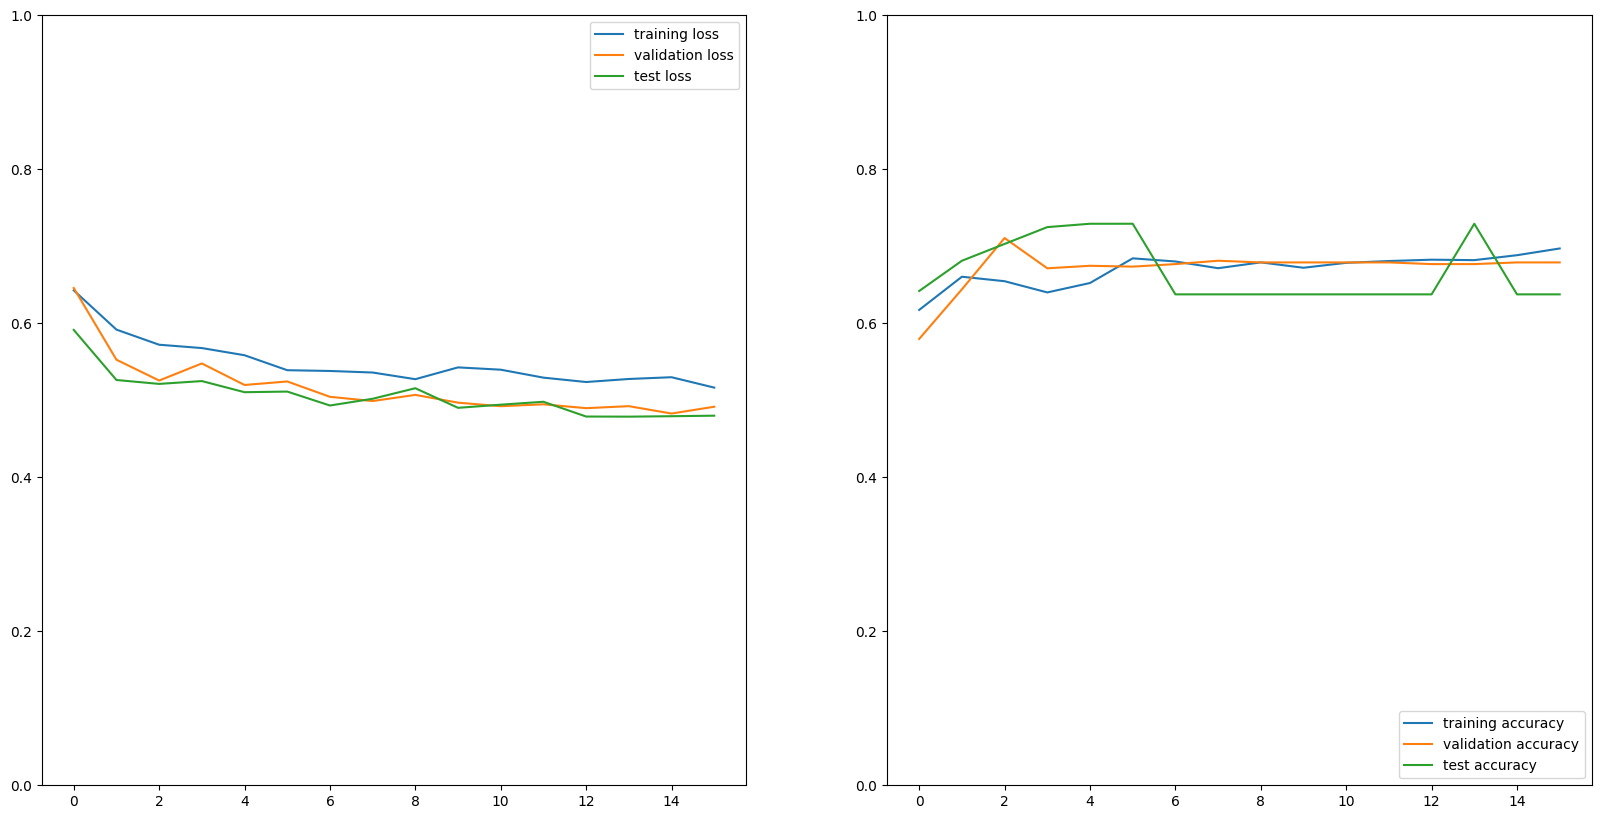

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(train_loss, label='training loss')
axs[0].plot(validation_loss, label='validation loss')
axs[0].plot(test_loss, label='test loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(train_acc, label='training accuracy')
axs[1].plot(validation_acc, label='validation accuracy')
axs[1].plot(test_acc, label='test accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)